In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
import torch
import pandas as pd
import re
import gc
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

from test_MLLMs import run_vlm_evaluation
from making_color_images.model_priors import ModelColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid, plot_vlm_performance, variant_label
from making_color_images.recolor_images import generate_variants, resize_all_images_and_masks


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
data_folder = WORK / "color-concept-entanglement" / "data"

fruit = data_folder / "fruit"
color_outlines = data_folder / "color_images"

## Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1. Simple Fruit Dataset

In [4]:
# Simple fruit dataset
evaluate_fruit = False
df = pd.read_parquet(fruit/ "fruit_images.parquet")

if evaluate_fruit:
    df_results = run_vlm_evaluation(
        df,
        processor,
        model,
        device,
        mode="both"
    )
    
    display(df_results)
    out_path = fruit / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (fruit / "outline_results.csv").exists():
    fruit_df = pd.read_csv(fruit / "outline_results.csv")
    display(fruit_df)

object  image_type                             image_path
0       banana   grayscale                data/fruit/banana1.jpeg
1       banana  background     data/fruit/banana1_background.jpeg
2       banana       color          data/fruit/banana1_color.jpeg
3       banana   grayscale                data/fruit/banana2.jpeg
4       banana  background     data/fruit/banana2_background.jpeg
5       banana       color          data/fruit/banana2_color.jpeg
6    blueberry   grayscale              data/fruit/blueberry.jpeg
7    blueberry  background   data/fruit/blueberry_background.jpeg
8    blueberry       color        data/fruit/blueberry_color.jpeg
9     cucumber   grayscale               data/fruit/cucumber.jpeg
10    cucumber  background    data/fruit/cucumber_background.jpeg
11    cucumber       color         data/fruit/cucumber_color.jpeg
12       lemon   grayscale                 data/fruit/lemon1.jpeg
13       lemon  background      data/fruit/lemon1_background.jpeg
14       lemon       color           data/fruit/lemon1_color.jpeg
15       lemon   grayscale                 data/fruit/lemon2.jpeg
16       lemon  background      data/fruit/lemon2_background.jpeg
17       lemon       color           data/fruit/lemon2_color.jpeg
18      orange   grayscale                data/fruit/orange1.jpeg
19      orange  background     data/fruit/orange1_background.jpeg
20      orange       color          data/fruit/orange1_color.jpeg
21      orange   grayscale                data/fruit/orange2.jpeg
22      orange  background     data/fruit/orange2_background.jpeg
23      orange       color          data/fruit/orange2_color.jpeg
24  strawberry   grayscale             data/fruit/strawberry.jpeg
25  strawberry  background  data/fruit/strawberry_background.jpeg
26  strawberry       color       data/fruit/strawberry_color.jpeg
27      tomato   grayscale                 data/fruit/tomato.jpeg
28      tomato  background      data/fruit/tomato_background.jpeg
29      tomato       color           data/fruit/tomato_color.jpeg

## 2. Outline Image Dataset 

## 2.1. Query world-knowledge color priors

In [5]:
# Load dataframe with outline images and masks
df = pd.read_csv(data_folder / "segmented_images.csv")
display(df)

correct_answer incorrect_answer              object  \
0                      ['yellow']           purple           sunflower   
1    ['brown', 'black', 'orange']            green               tabby   
2               ['pink', 'white']            green           spoonbill   
3                       ['white']            green             Samoyed   
4               ['grey', 'black']              red  Norwegian elkhound   
..                            ...              ...                 ...   
215            ['gold', 'silver']            green               crown   
216           ['orange', 'white']           purple         pill bottle   
217                     ['black']             pink      dial telephone   
218                     ['black']             pink       digital watch   
219             ['yellow', 'red']           purple           tow truck   

                                             image_url  \
0    https://thumbs.dreamstime.com/b/black-outline-...   
1    https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...   
2    https://img.freepik.com/premium-vector/drawing...   
3    https://img.freepik.com/premium-photo/black-wh...   
4    https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...   
..                                                 ...   
215  https://i.pinimg.com/736x/32/52/35/325235d85fb...   
216  https://media.istockphoto.com/id/470313936/vec...   
217  https://png.pngtree.com/png-clipart/20230811/o...   
218  https://img.freepik.com/premium-vector/digital...   
219  https://pics.coloringsai.com/tow-mater-colorin...   

                                            image_path  \
0    /mnt/lustre/work/eickhoff/esx061/color-concept...   
1    /mnt/lustre/work/eickhoff/esx061/color-concept...   
2    /mnt/lustre/work/eickhoff/esx061/color-concept...   
3    /mnt/lustre/work/eickhoff/esx061/color-concept...   
4    /mnt/lustre/work/eickhoff/esx061/color-concept...   
..                                                 ...   
215  /mnt/lustre/work/eickhoff/esx061/color-concept...   
216  /mnt/lustre/work/eickhoff/esx061/color-concept...   
217  /mnt/lustre/work/eickhoff/esx061/color-concept...   
218  /mnt/lustre/work/eickhoff/esx061/color-concept...   
219  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                          gpt_response  score  watermark  \
0    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
1    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
2    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
3    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
4    {'white_background': 'yes', 'style': 'illustra...   47.0      False   
..                                                 ...    ...        ...   
215  {'white_background': 'yes', 'style': 'illustra...   42.0      False   
216  {'white_background': 'yes', 'style': 'illustra...   35.0      False   
217  {'white_background': 'yes', 'style': 'illustra...   35.0      False   
218  {'white_background': 'yes', 'style': 'illustra...   34.0      False   
219  {'white_background': 'yes', 'style': 'illustra...   33.0      False   

     num_objects                                       cv_mask_path  \
0            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
1            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
2            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
3            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
4            1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
..           ...                                                ...   
215          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
216          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
217          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
218          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
219          1.0  /mnt/lustre/work/eickhof

In [6]:
# Constrict df for testing
df = df.head(3)

In [7]:
# Initalize ModelColorPriors
priors = ModelColorPriors(
    processor=processor,
    model=model,
    data_folder=data_folder,
    device=device
)

In [8]:
# Generate new priors
ground_truth_df = priors.get_model_color_priors(df)

Running model color priors: 100%|██████████| 3/3 [00:15<00:00,  5.02s/it]

Saved model priors to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/model_color_priors.csv


In [9]:
# Checkpoint: display the generated priors
ground_truth_df = pd.read_csv(data_folder / "model_color_priors.csv")
display(ground_truth_df[['object', 'correct_answer', 'model_prior_dummy', 'model_prior']])

object                correct_answer model_prior_dummy model_prior
0  sunflower                    ['yellow']            yellow      yellow
1      tabby  ['brown', 'black', 'orange']            orange        grey
2  spoonbill             ['pink', 'white']             white       white

In [10]:
# Analyze dummy vs real
ground_truth_df = priors.analyze_differences(ground_truth_df)

1 rows differ between dummy and real priors.
1 rows where model color prior NOT in ground truth.
Model color priors: ['yellow' 'grey' 'white']


In [11]:
# Replace correct_answer in main df with model priors
df = priors.replace_correct_answers(df, ground_truth_df)
df["correct_answer"].value_counts()

Excluding colors: ['silver', 'gold', 'white', 'clear']
Updated dataset now has 2 rows.


correct_answer
yellow    1
grey      1
Name: count, dtype: int64

In [12]:
# Optional load
# ground_truth_df = priors.load_model_priors()

## 2.2. Resize images and masks

In [13]:
RESIZED_IMGS = data_folder / "resized_images"
RESIZED_MASKS = data_folder / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

df = resize_all_images_and_masks(
    df,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)


Resizing all: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]

Resized 2 images.


## 2.3. Recolor outline images with model prior

In [14]:
# Sample one image per color for fast testing
colors  = df['correct_answer'].unique().tolist()
df = df.groupby("correct_answer", group_keys=False).apply(lambda x: x.sample(1, random_state=SEED), include_groups=True).reset_index(drop=True)
display(df)

/tmp/ipykernel_477022/615141465.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("correct_answer", group_keys=False).apply(lambda x: x.sample(1, random_state=SEED), include_groups=True).reset_index(drop=True)


correct_answer incorrect_answer     object  \
0         yellow           purple  sunflower   
1           grey            green      tabby   

                                           image_url  \
0  https://thumbs.dreamstime.com/b/black-outline-...   
1  https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...   

                                          image_path  \
0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
1  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                        gpt_response  score  watermark  \
0  {'white_background': 'yes', 'style': 'illustra...   47.0      False   
1  {'white_background': 'yes', 'style': 'illustra...   47.0      False   

   num_objects                                       cv_mask_path  \
0          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   
1          1.0  /mnt/lustre/work/eickhoff/esx061/color-concept...   

                                       sam_mask_path  
0  /mnt/lustre/work/eickhoff/esx061/color-concept...  
1  /mnt/lustre/work/eickhoff/esx061/color-concept...

In [15]:
# Only evaluate first few images for testing
#df = df.head(2)

In [16]:
# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 110, 10))
print(pct_schedule)

# Set coloring modes
coloring_modes = ["sequential"] #, "independent"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [27]:
# Generate variants for all images in df
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=color_outlines,
            rng=rng,
            use_patches=True,
            patch_size=16,
            step_size=10,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

Generating color variants:   0%|          | 0/2 [00:00<?, ?it/s]

[FG] target=  0% → actual=  0.00%   (0/129279)
[FG] target=  1% → actual=  1.16%   (1495/129279)
[FG] target=  2% → actual=  2.14%   (2769/129279)
[FG] target=  3% → actual=  3.08%   (3985/129279)
[FG] target=  4% → actual=  4.11%   (5318/129279)
[FG] target=  5% → actual=  5.04%   (6513/129279)
[FG] target=  6% → actual=  6.16%   (7964/129279)
[FG] target=  7% → actual=  7.01%   (9065/129279)
[FG] target=  8% → actual=  8.09%   (10464/129279)
[FG] target=  9% → actual=  9.16%   (11841/129279)
[FG] target= 10% → actual= 10.16%   (13133/129279)
[FG] target= 20% → actual= 20.01%   (25873/129279)
[FG] target= 30% → actual= 30.11%   (38924/129279)
[FG] target= 40% → actual= 40.03%   (51746/129279)
[FG] target= 50% → actual= 50.09%   (64750/129279)
[FG] target= 60% → actual= 60.11%   (77708/129279)
[FG] target= 70% → actual= 70.07%   (90589/129279)
[FG] target= 80% → actual= 80.12%   (103577/129279)
[FG] target= 90% → actual= 90.00%   (116357/129279)
[FG] target=100% → actual=100.00%   (129

Generating color variants:  50%|█████     | 1/2 [00:07<00:07,  7.85s/it]

[BG] target=100% → actual=100.00%   (113723/113723)
[FG] target=  0% → actual=  0.00%   (0/85260)
[FG] target=  1% → actual=  1.08%   (918/85260)
[FG] target=  2% → actual=  2.05%   (1752/85260)
[FG] target=  3% → actual=  3.16%   (2690/85260)
[FG] target=  4% → actual=  4.27%   (3637/85260)
[FG] target=  5% → actual=  5.17%   (4410/85260)
[FG] target=  6% → actual=  6.18%   (5269/85260)
[FG] target=  7% → actual=  7.08%   (6038/85260)
[FG] target=  8% → actual=  8.28%   (7061/85260)
[FG] target=  9% → actual=  9.23%   (7870/85260)
[FG] target= 10% → actual= 10.14%   (8648/85260)
[FG] target= 20% → actual= 20.23%   (17250/85260)
[FG] target= 30% → actual= 30.29%   (25824/85260)
[FG] target= 40% → actual= 40.13%   (34217/85260)
[FG] target= 50% → actual= 50.09%   (42704/85260)
[FG] target= 60% → actual= 60.06%   (51208/85260)
[FG] target= 70% → actual= 70.17%   (59831/85260)
[FG] target= 80% → actual= 80.15%   (68340/85260)
[FG] target= 90% → actual= 90.09%   (76812/85260)
[FG] target=1

Generating color variants: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it]

[BG] target=100% → actual=100.00%   (176210/176210)


In [20]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

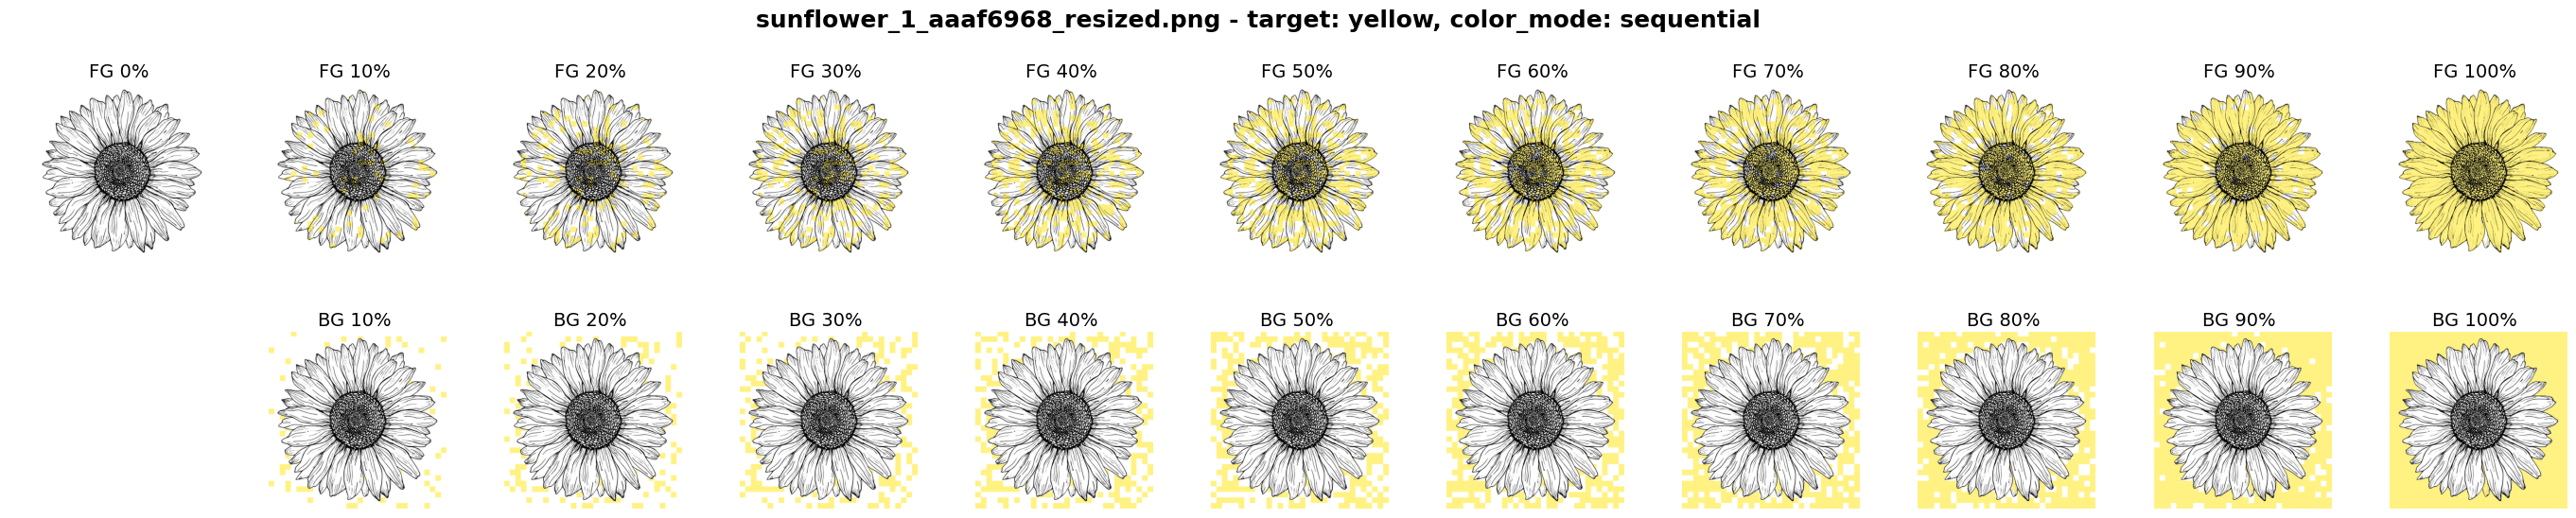

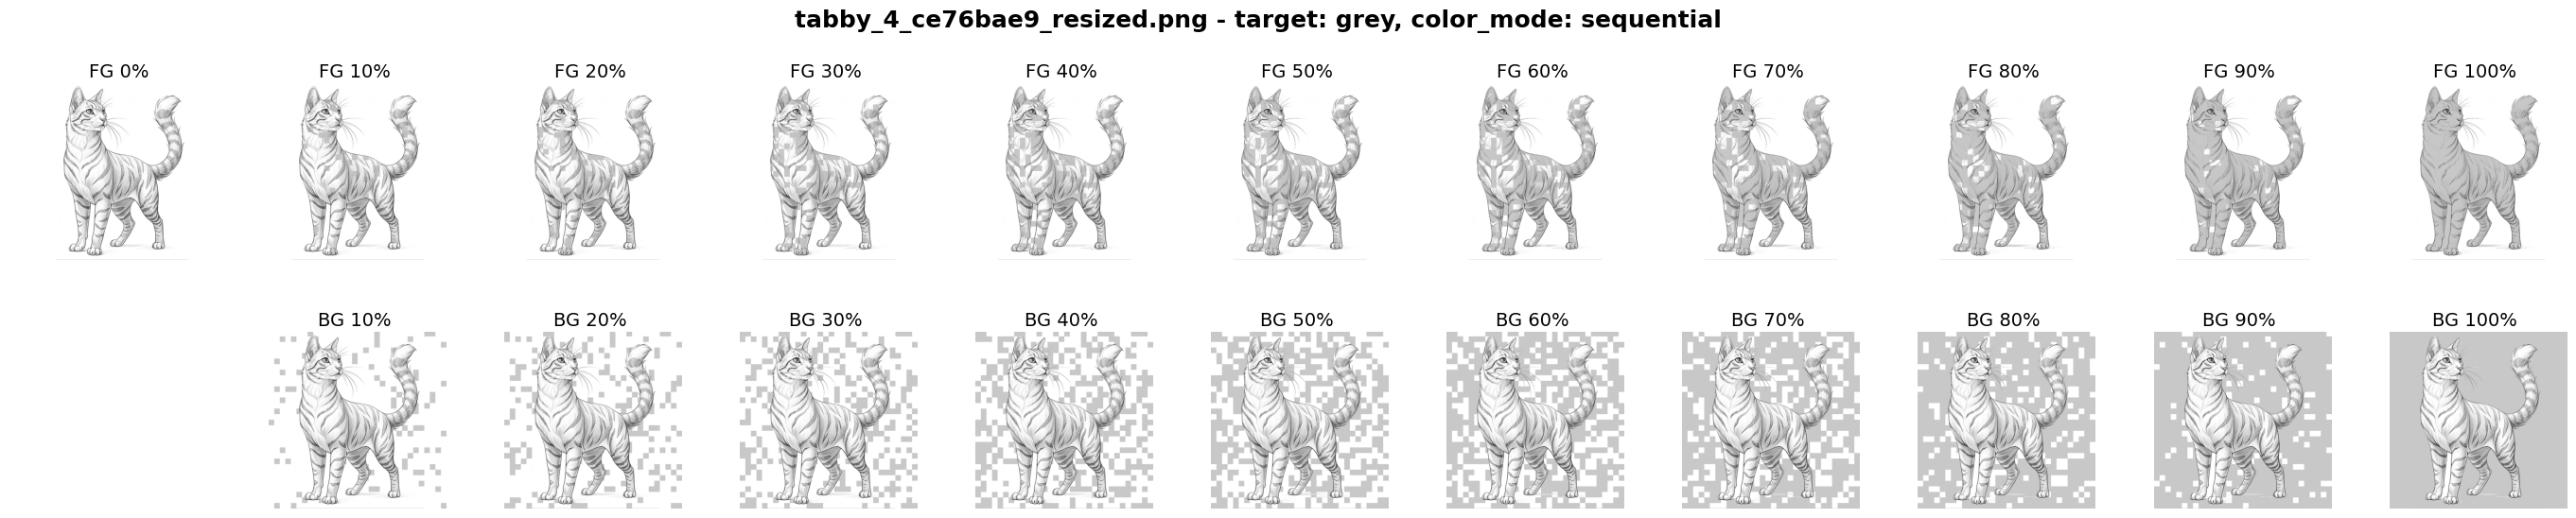

In [25]:
for idx, row in df.iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['correct_answer'], color_outlines, color_mode=color_mode, pct_range=ten_increase)

## 2.4. Evaluate open-weight models on recolored image variants

In [ ]:
# Main evaluation of color outline variants for BOTH independent and sequential coloring
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects"):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["correct_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="both",
        return_probs=True   
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this", "prob_correct_most", "prob_correct_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_color_df = pd.concat(preds, ignore_index=True)

out_path = data_folder / "outline_results.csv"
pred_color_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_color_df.head(10))

Running outline variant evaluation...


Evaluating objects:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Checkpoint
pred_color_df = pd.read_csv(data_folder / "outline_results.csv")

In [ ]:
pred_color_df

object  image_variant correct_answer pred_color_most  \
0     keyboard_(musical)    BG 0% (ind)          black           black   
1     keyboard_(musical)    BG 0% (seq)          black           black   
2     keyboard_(musical)    BG 1% (ind)          black           black   
3     keyboard_(musical)    BG 1% (seq)          black           black   
4     keyboard_(musical)    BG 2% (ind)          black           black   
...                  ...            ...            ...             ...   
1155              banana   FG 98% (seq)         yellow          yellow   
1156              banana   FG 99% (ind)         yellow          yellow   
1157              banana   FG 99% (seq)         yellow          yellow   
1158              banana  FG 100% (ind)         yellow          yellow   
1159              banana  FG 100% (seq)         yellow          yellow   

     pred_color_this  prob_correct_most  prob_correct_this  
0              black           0.592285           0.561523  
1              black           0.592285           0.561523  
2              black           0.584473           0.581543  
3              black           0.614258           0.628418  
4              black           0.562012           0.565430  
...              ...                ...                ...  
1155          yellow           0.986816           0.980957  
1156          yellow           0.985840           0.979004  
1157          yellow           0.986328           0.980957  
1158          yellow           0.987305           0.981934  
1159          yellow           0.987305           0.981934  

[1160 rows x 7 columns]

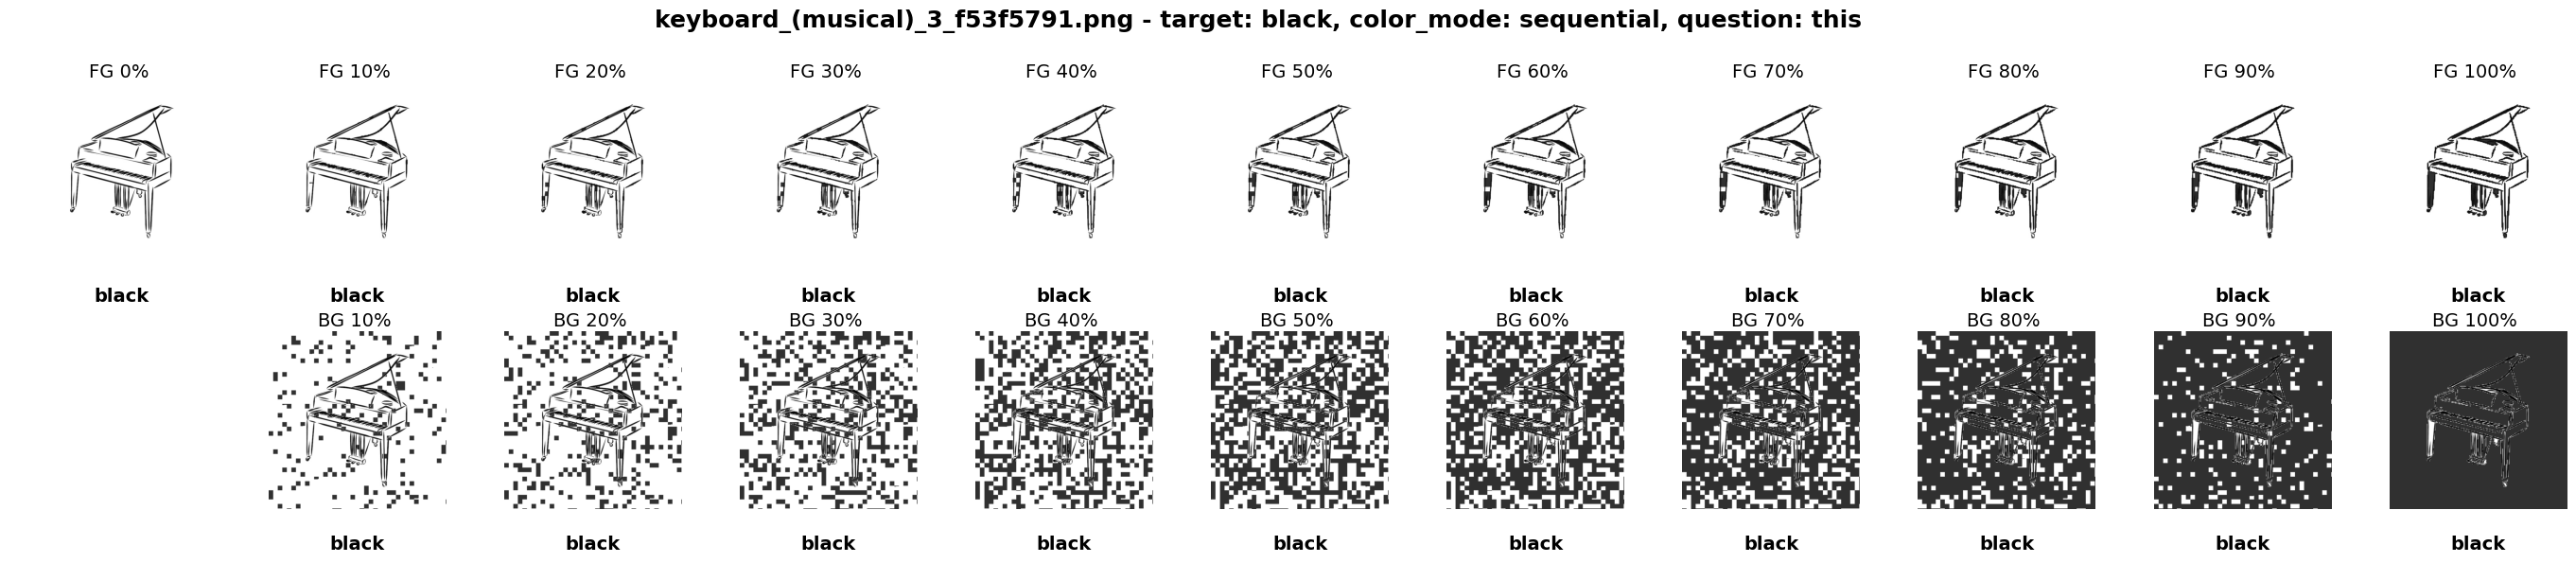

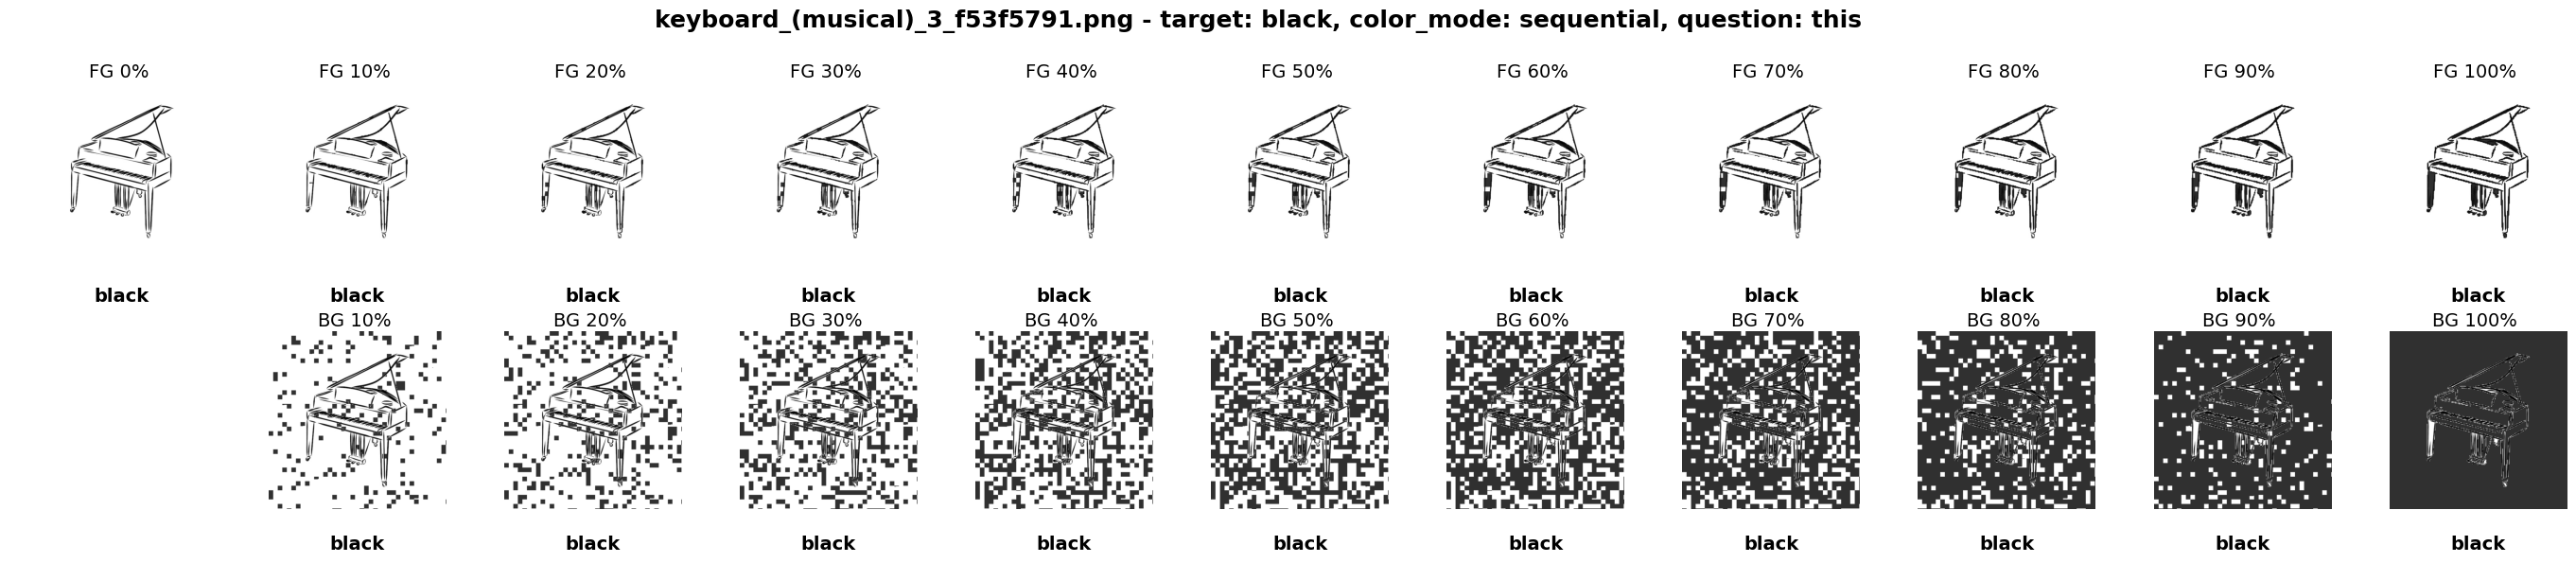

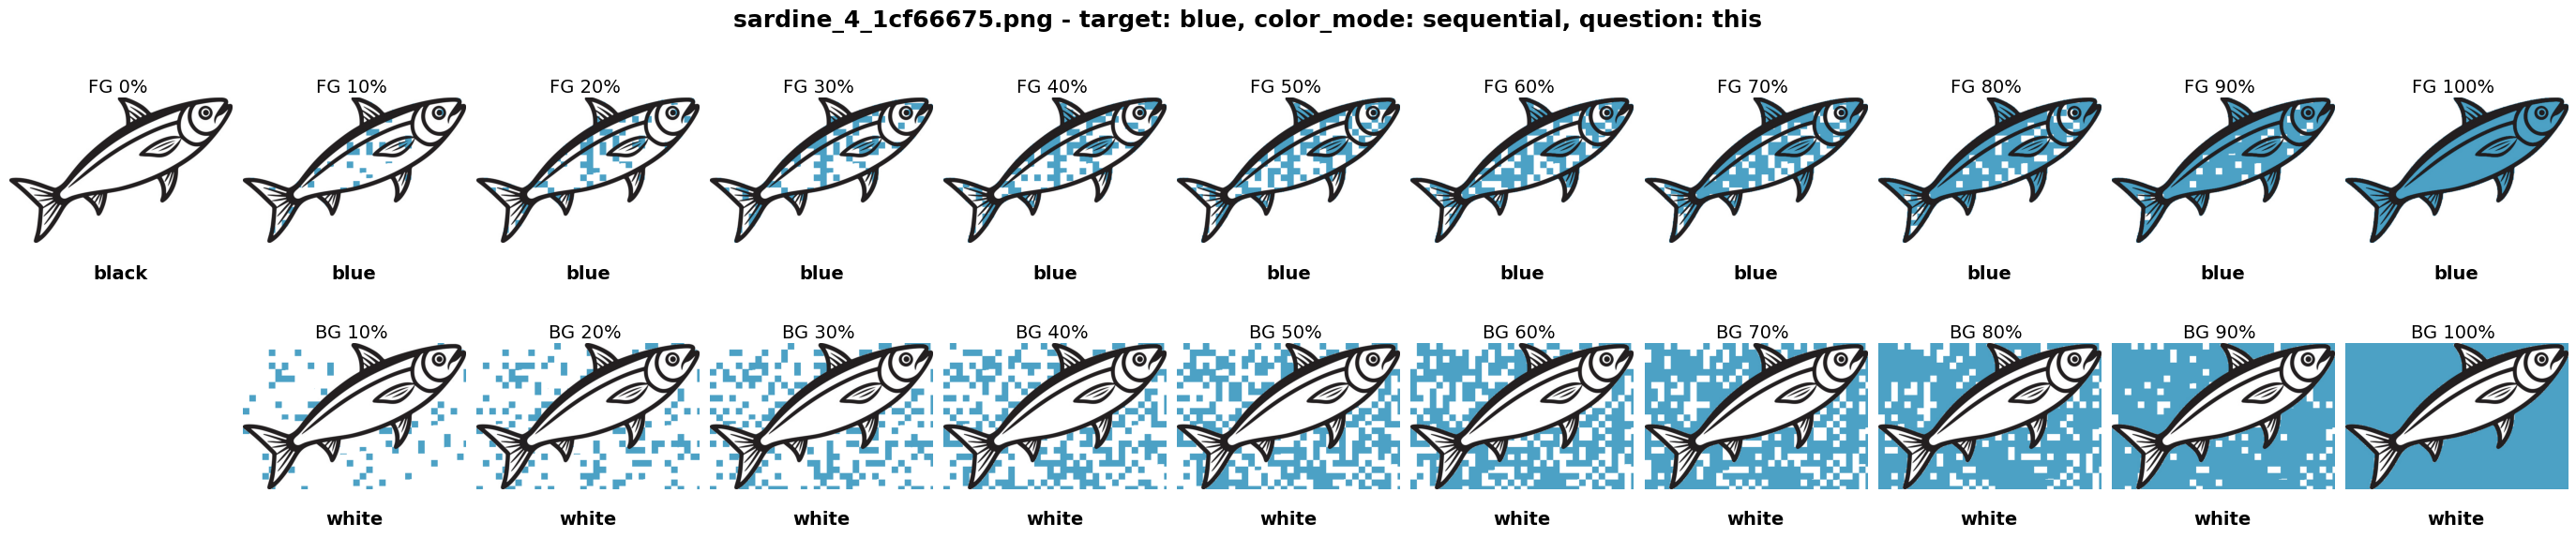

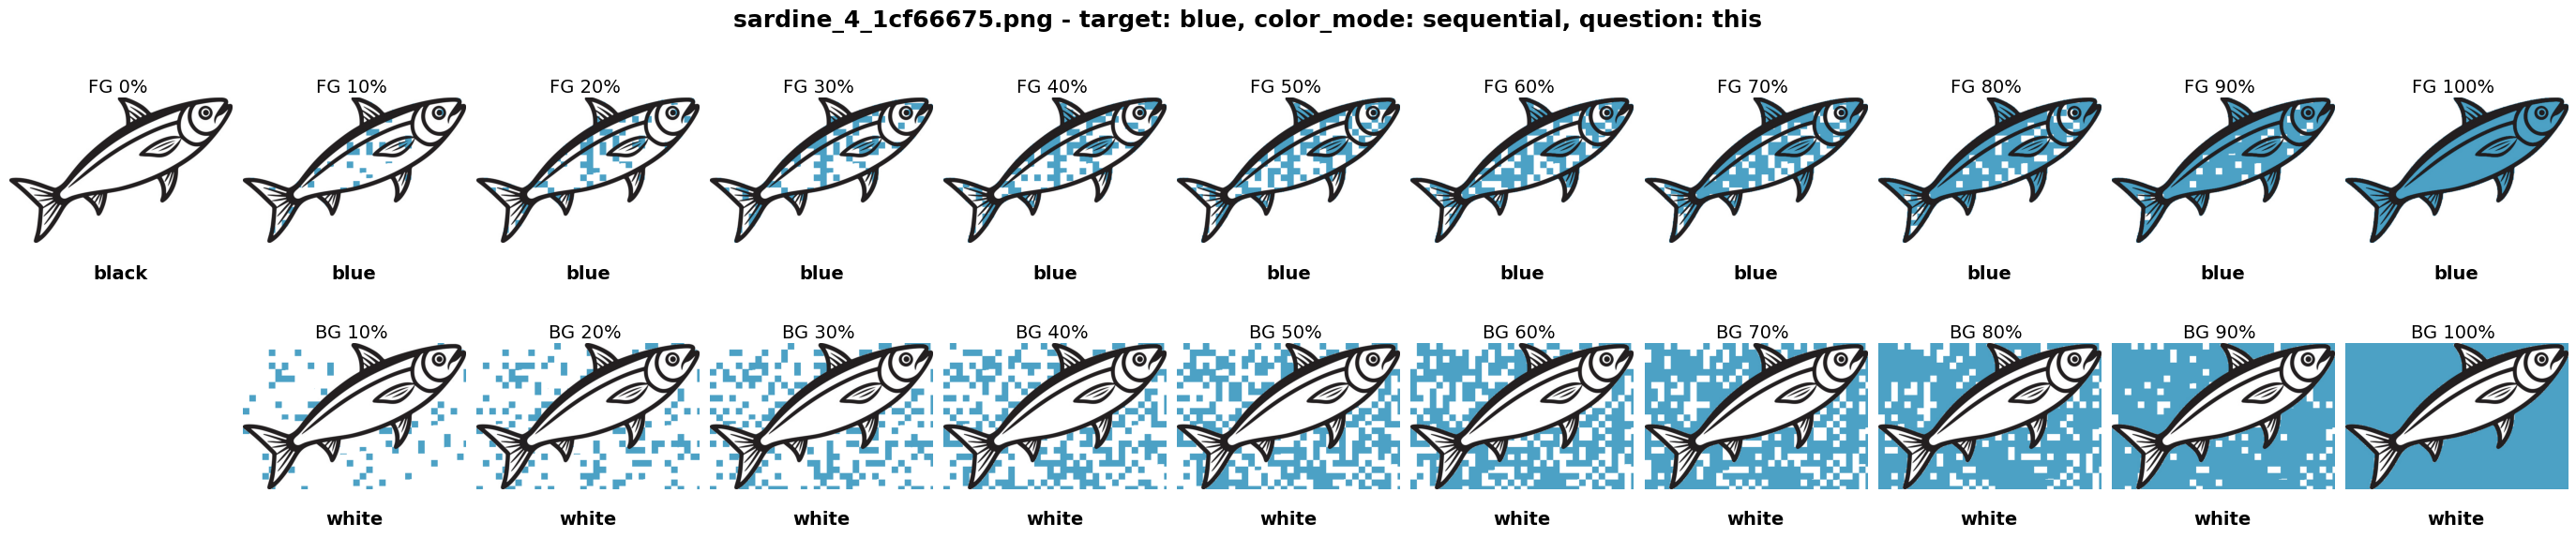

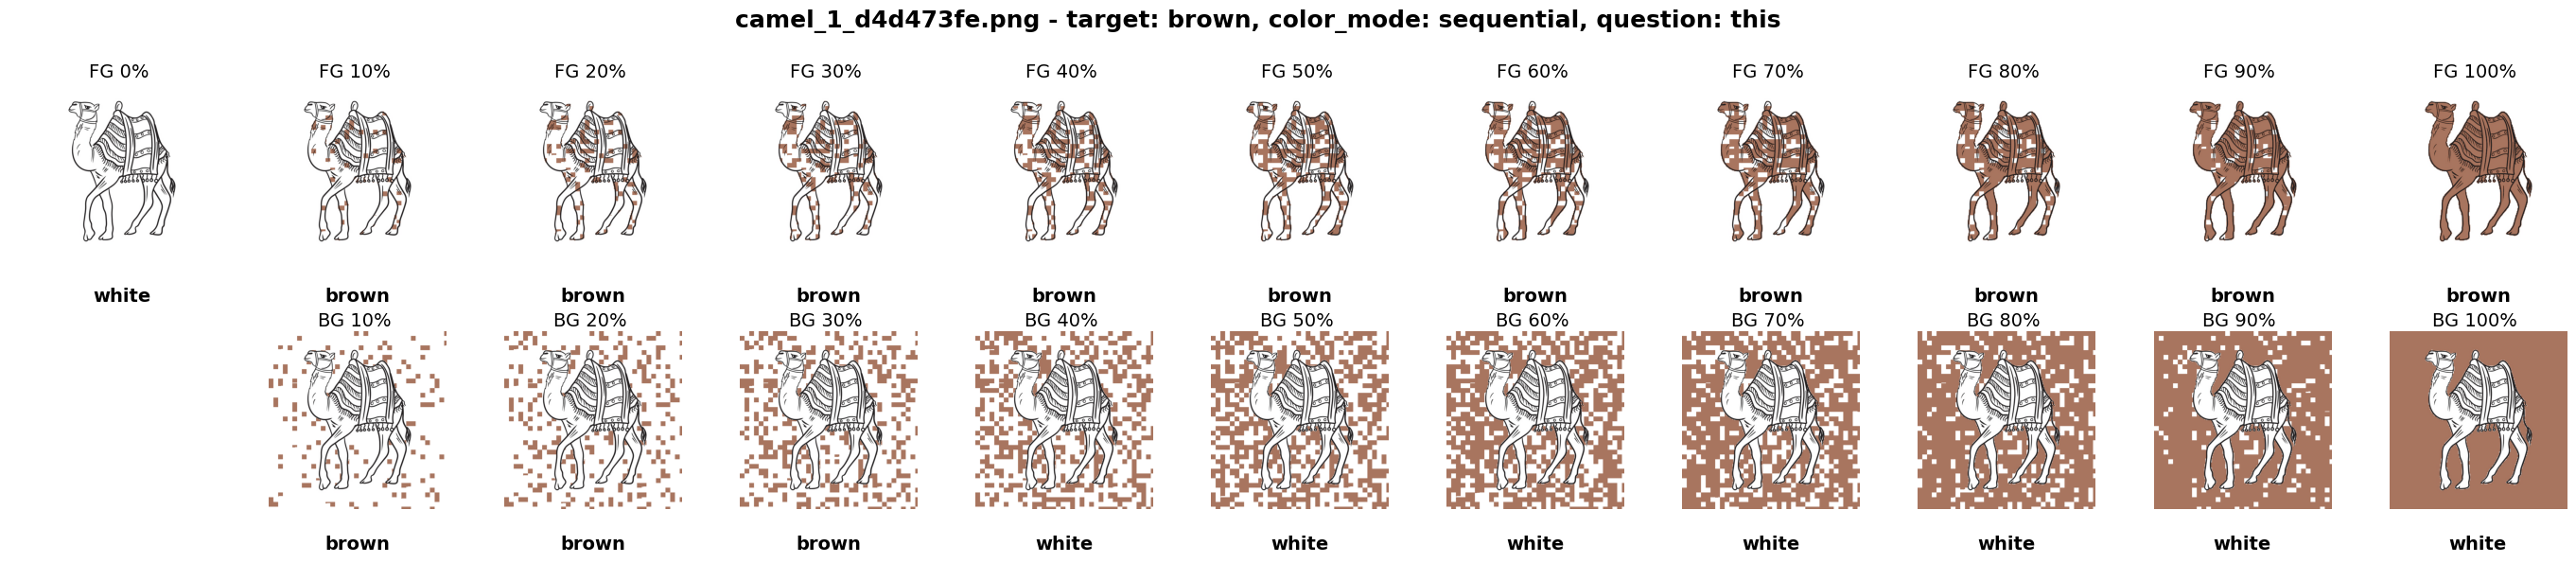

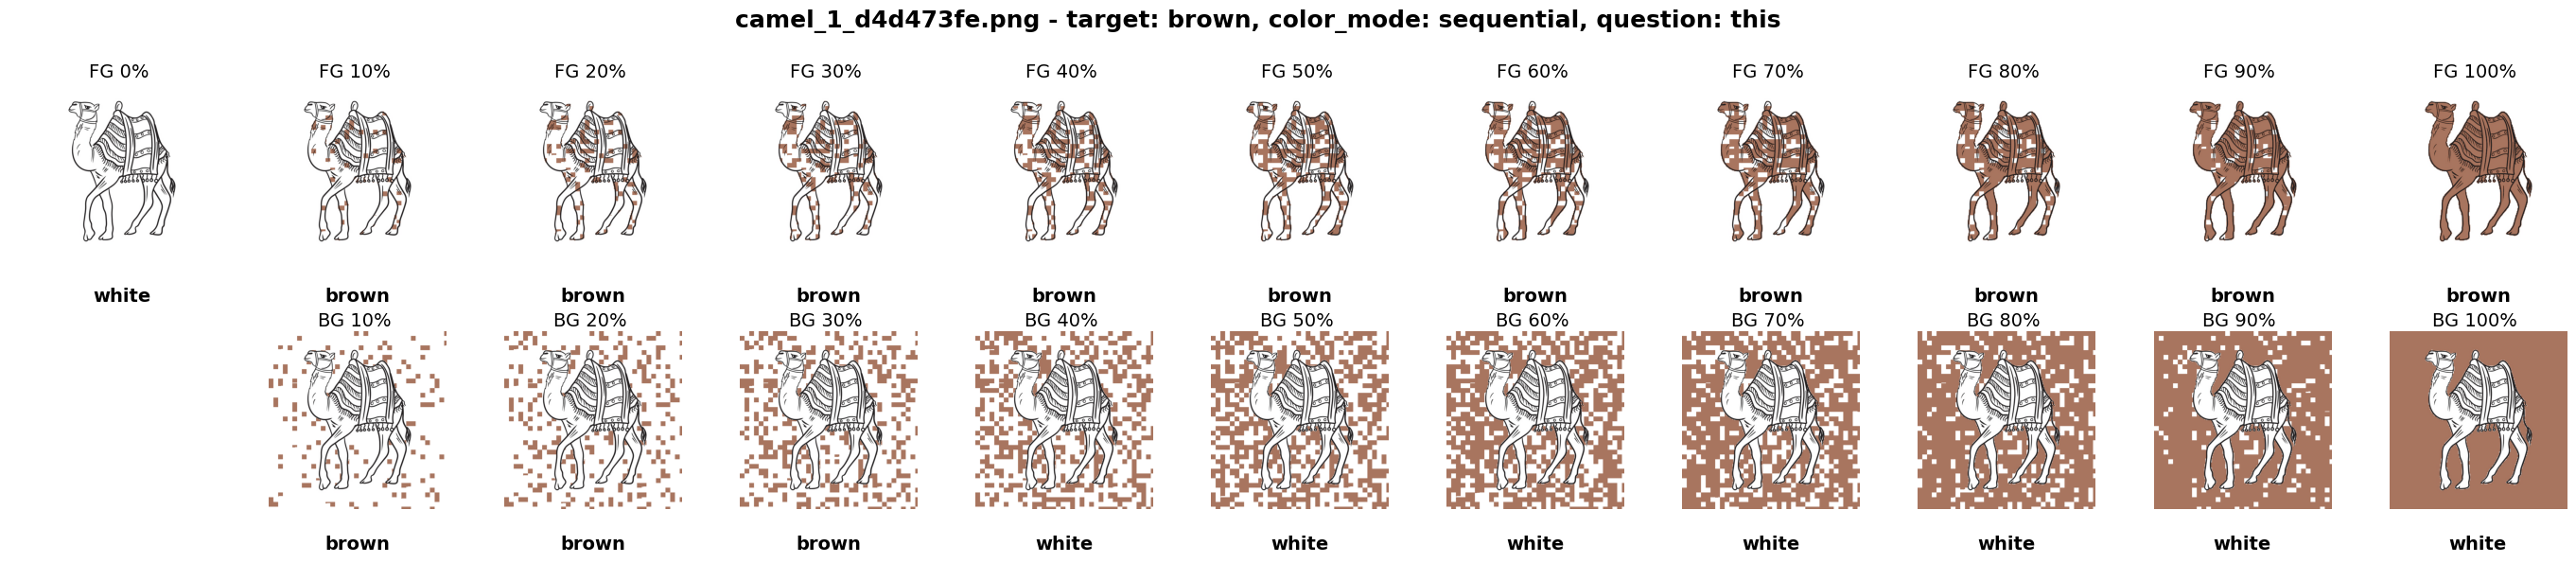

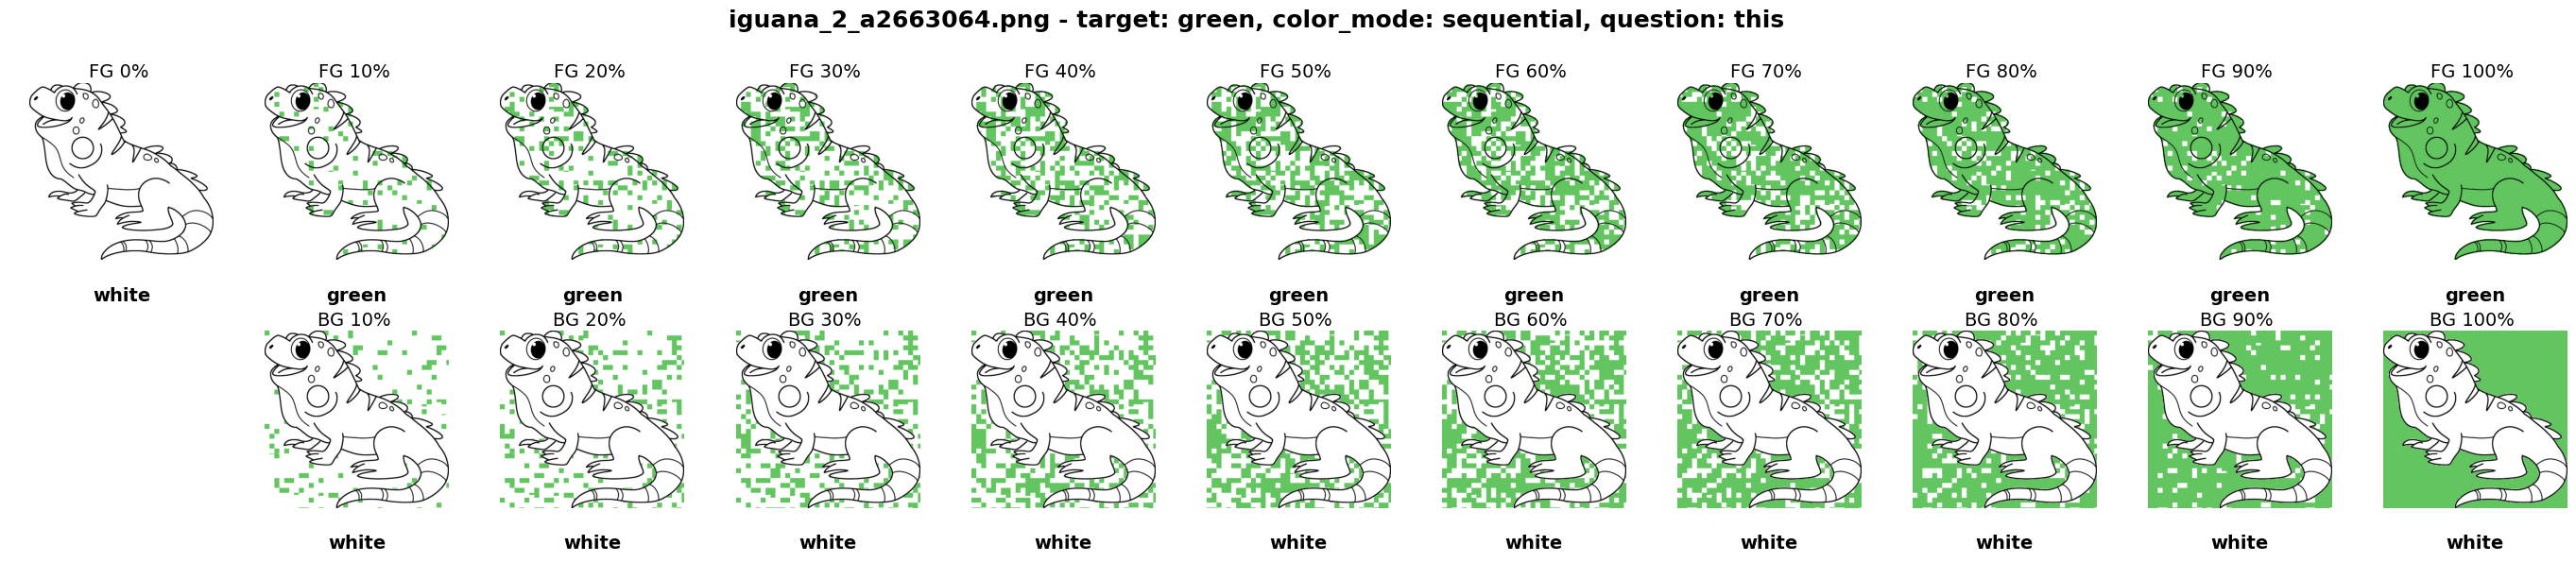

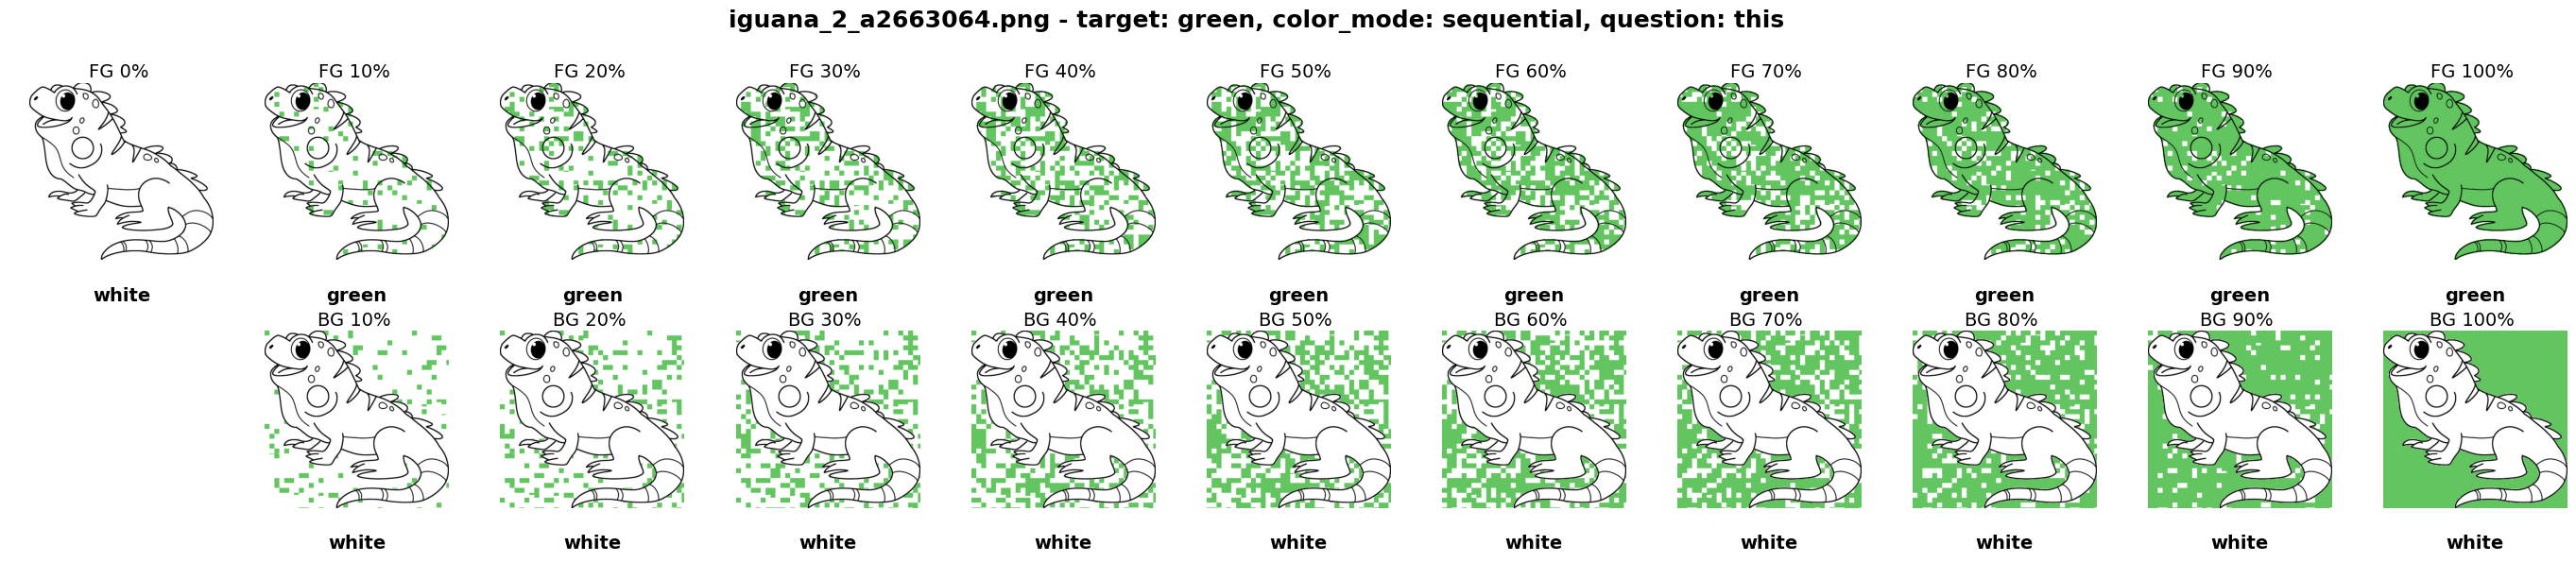

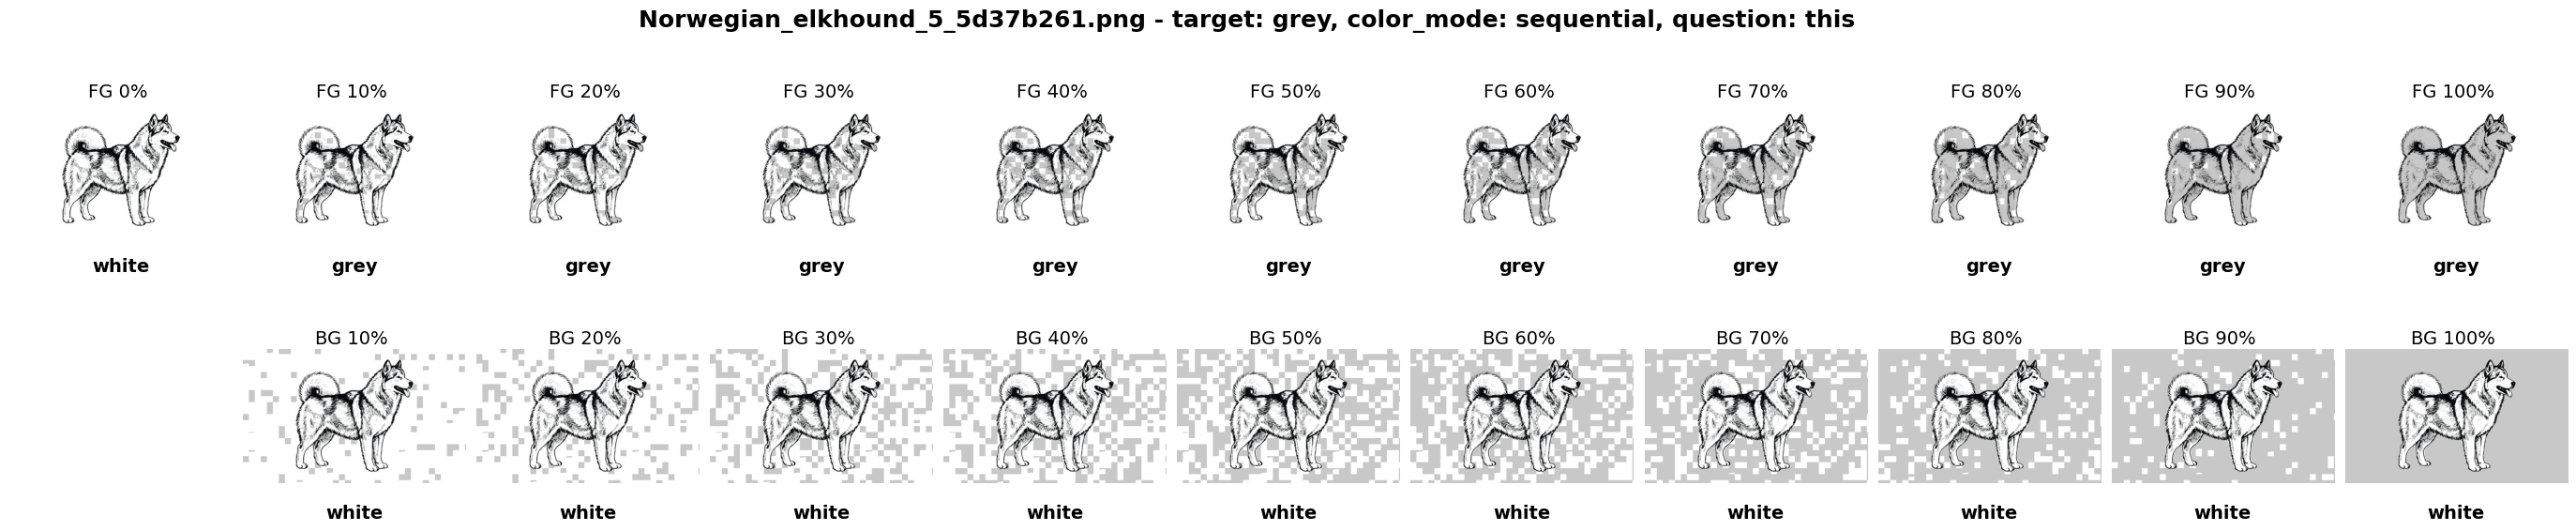

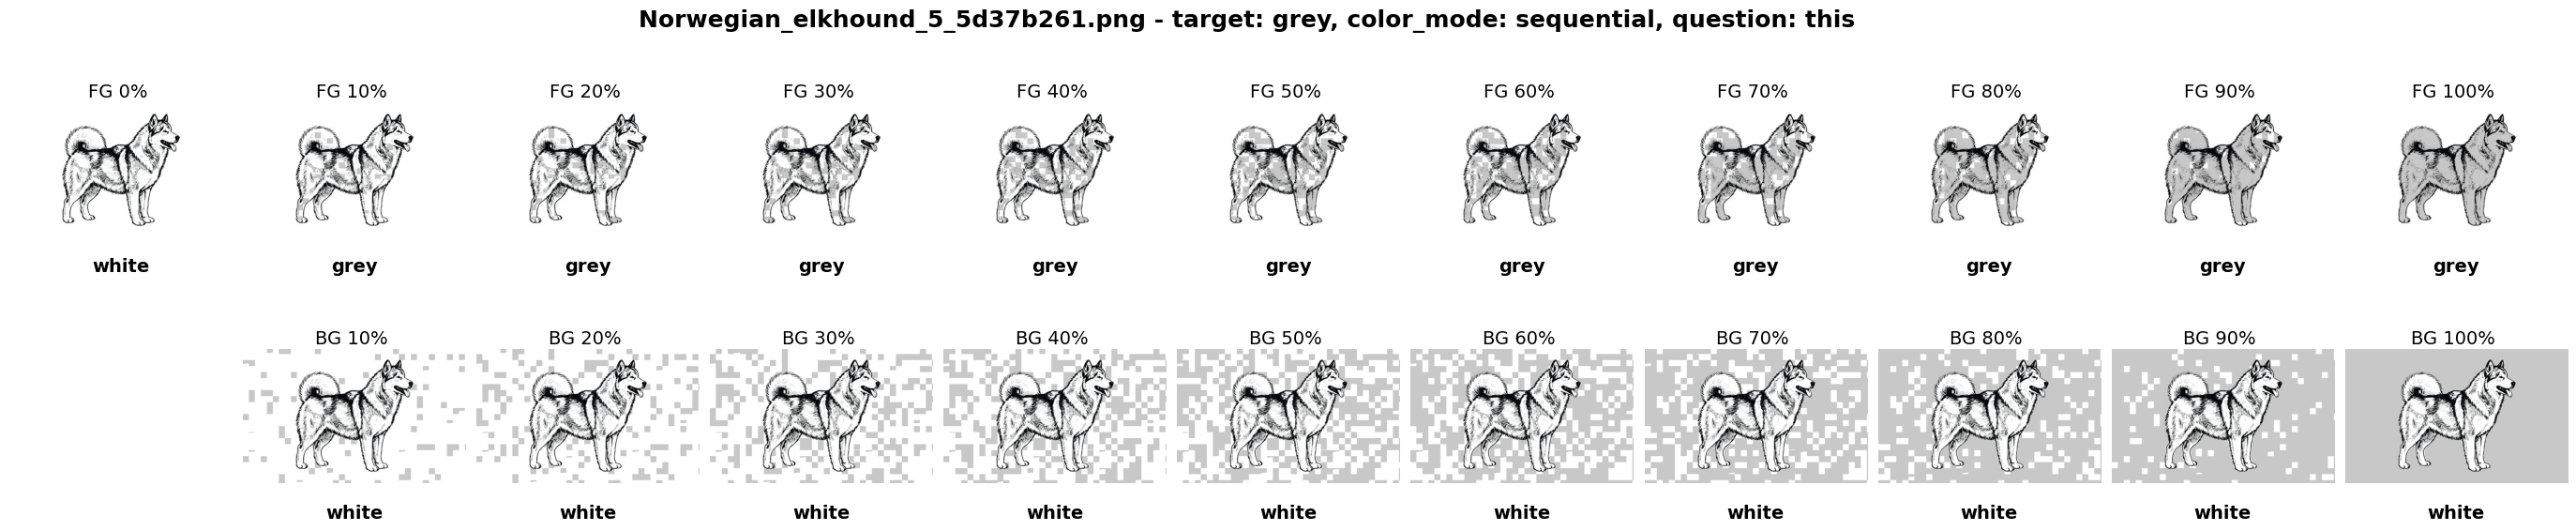

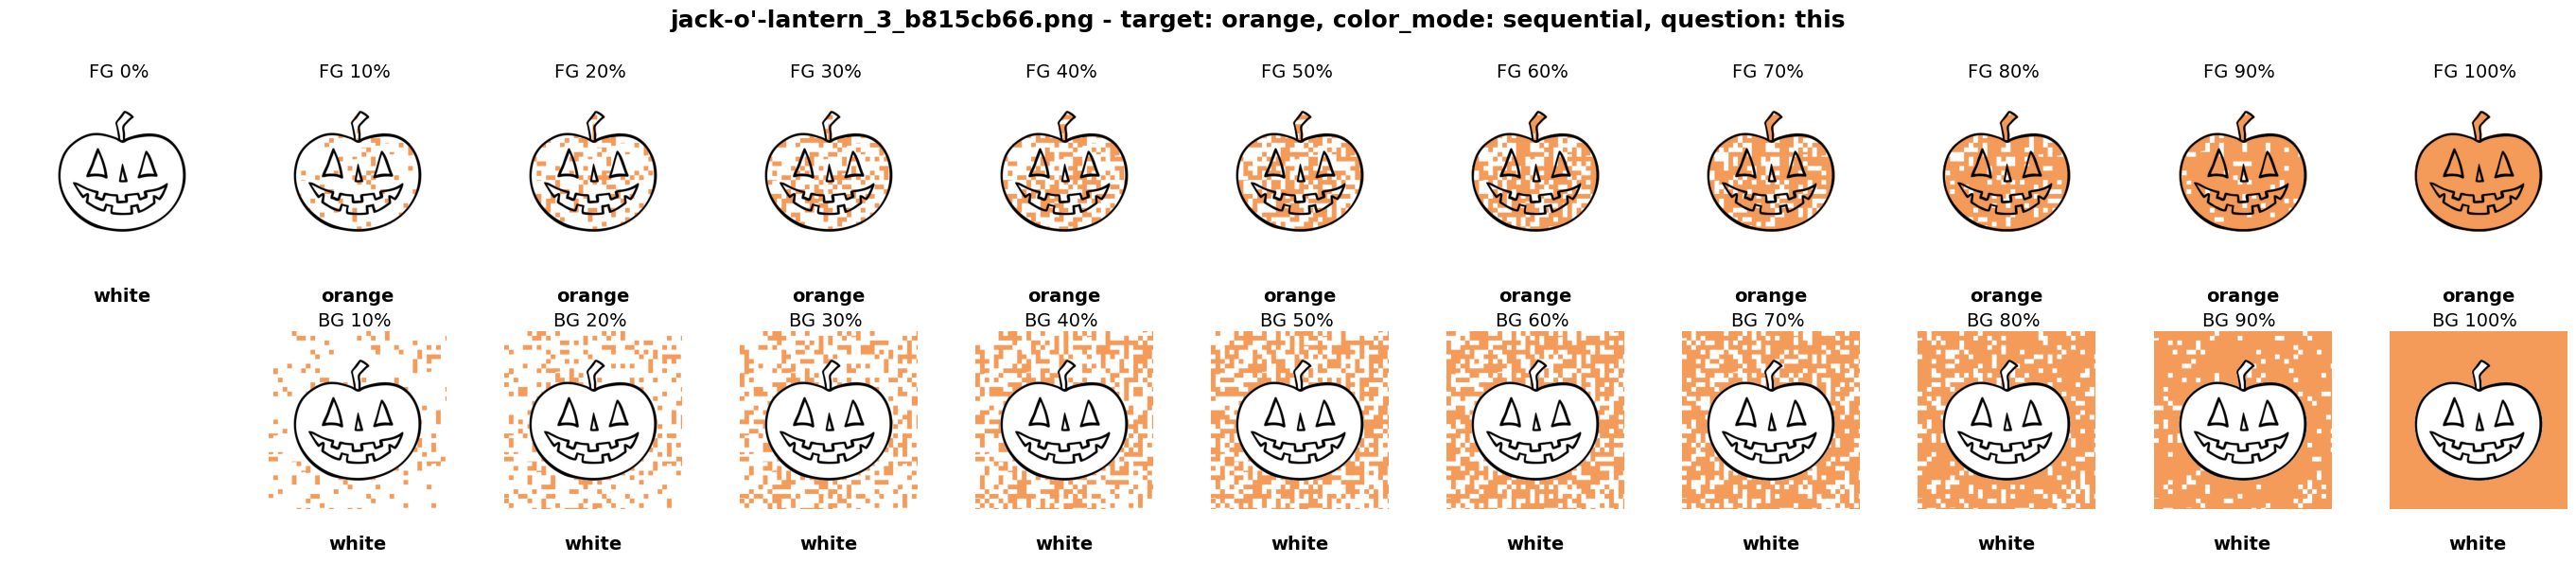

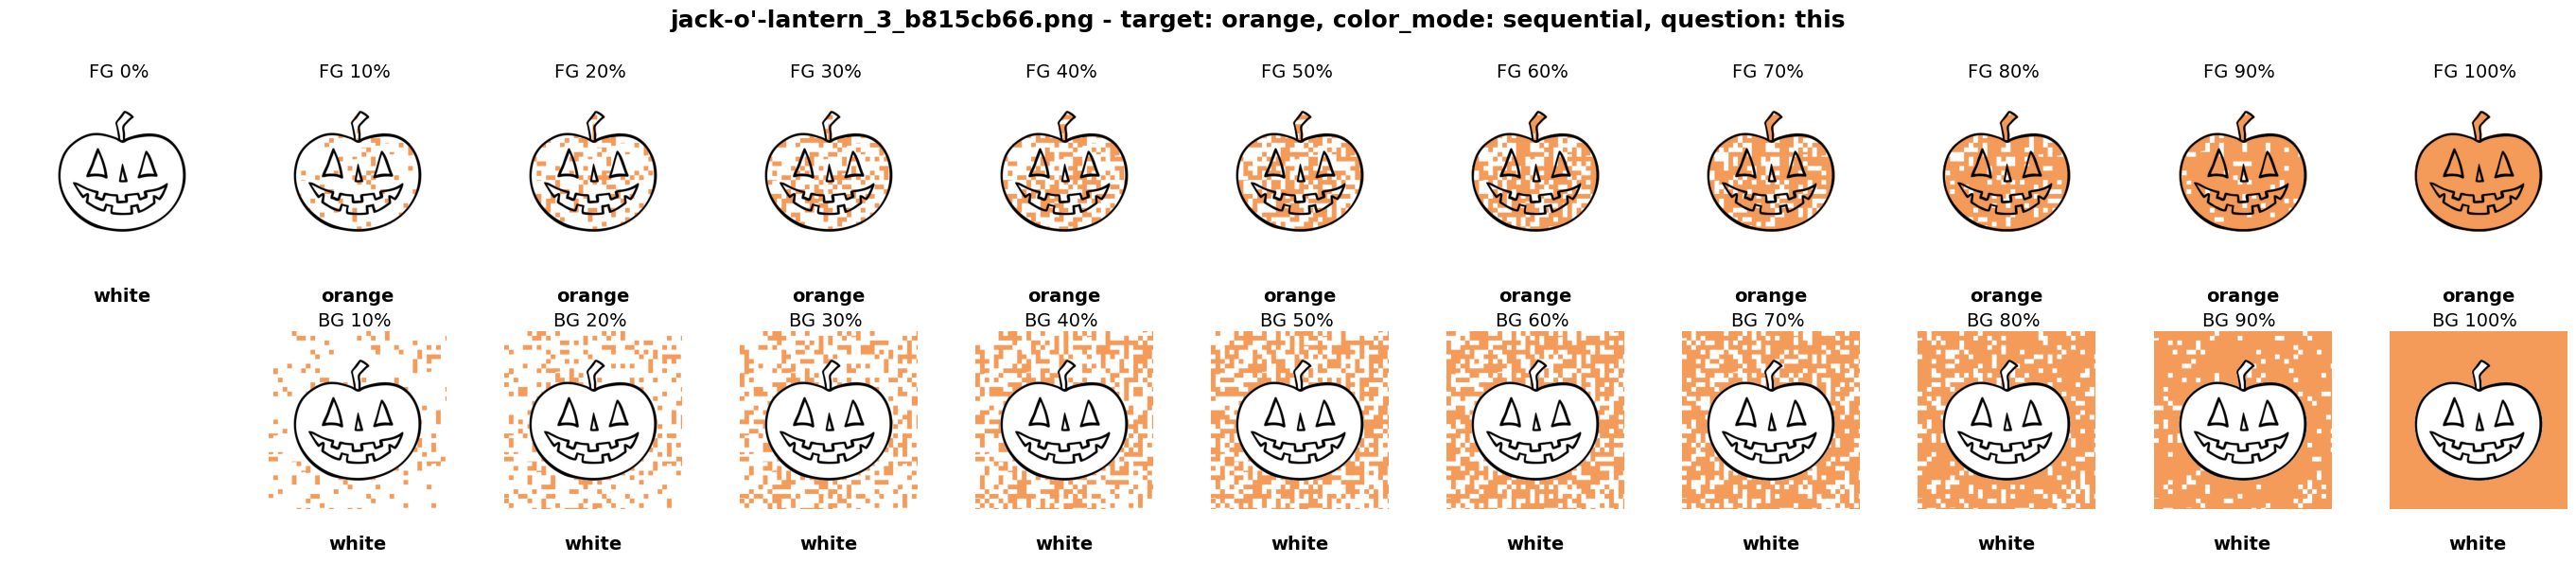

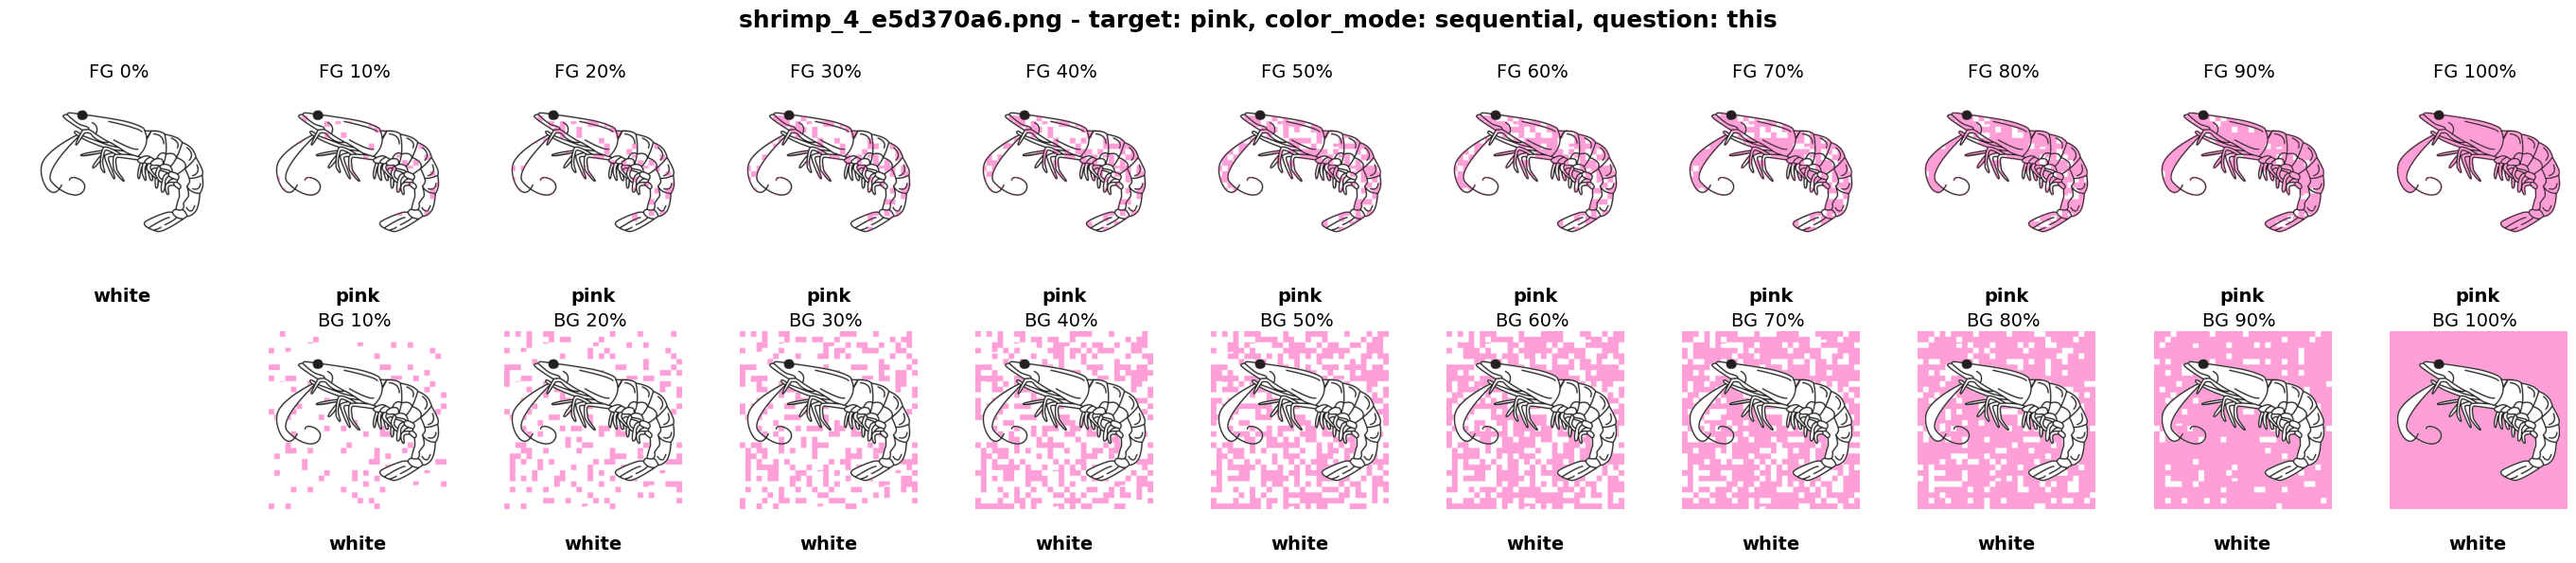

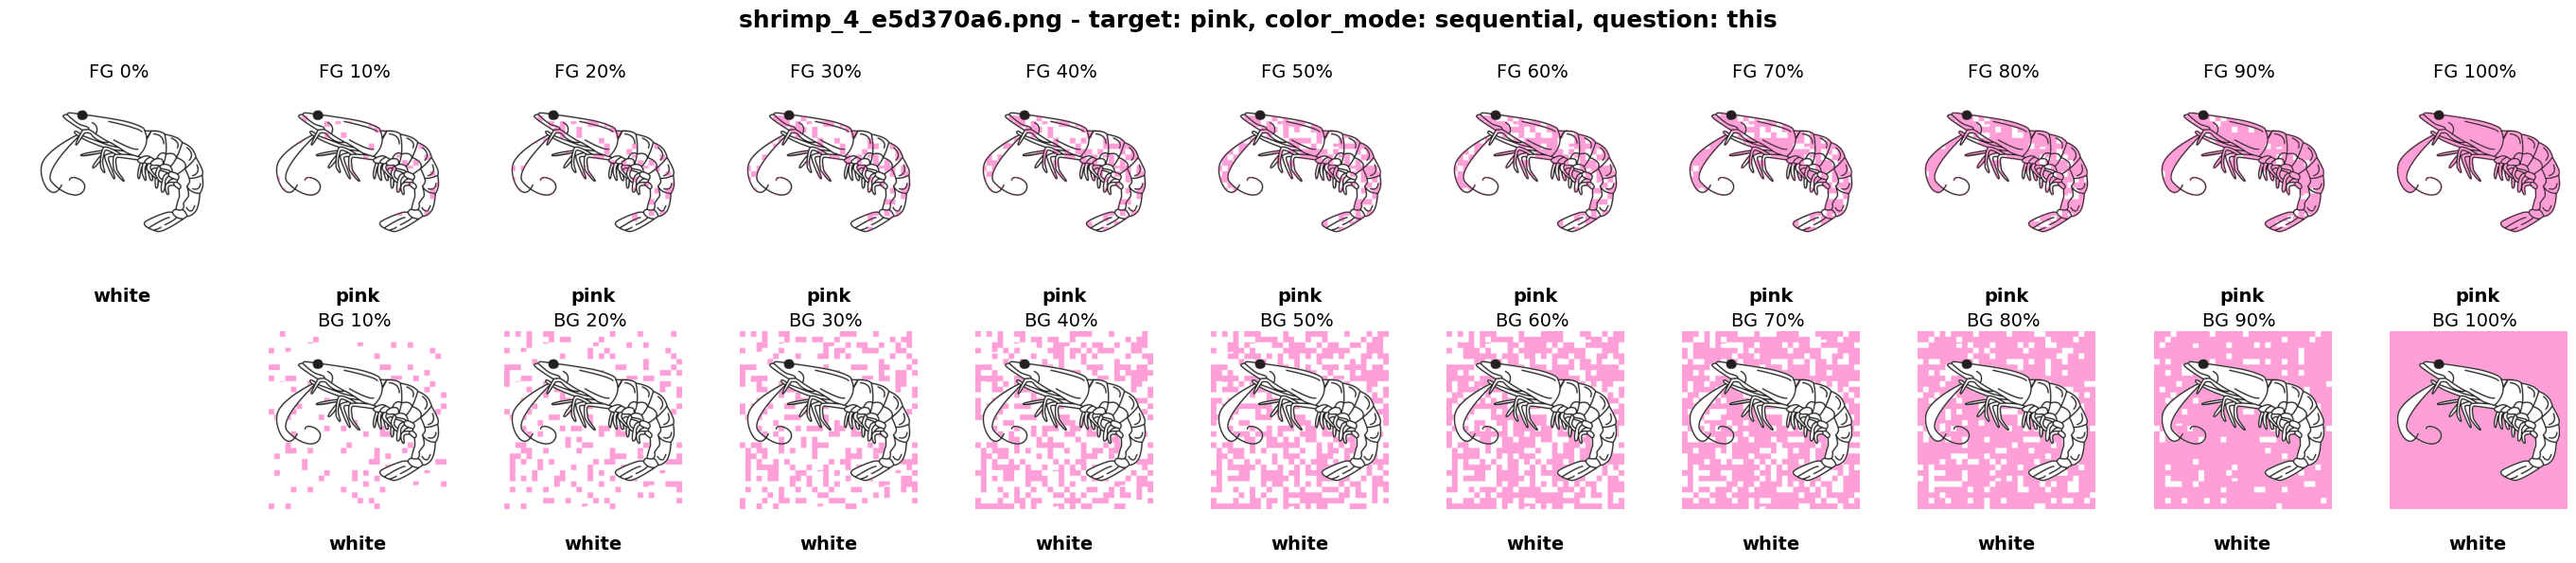

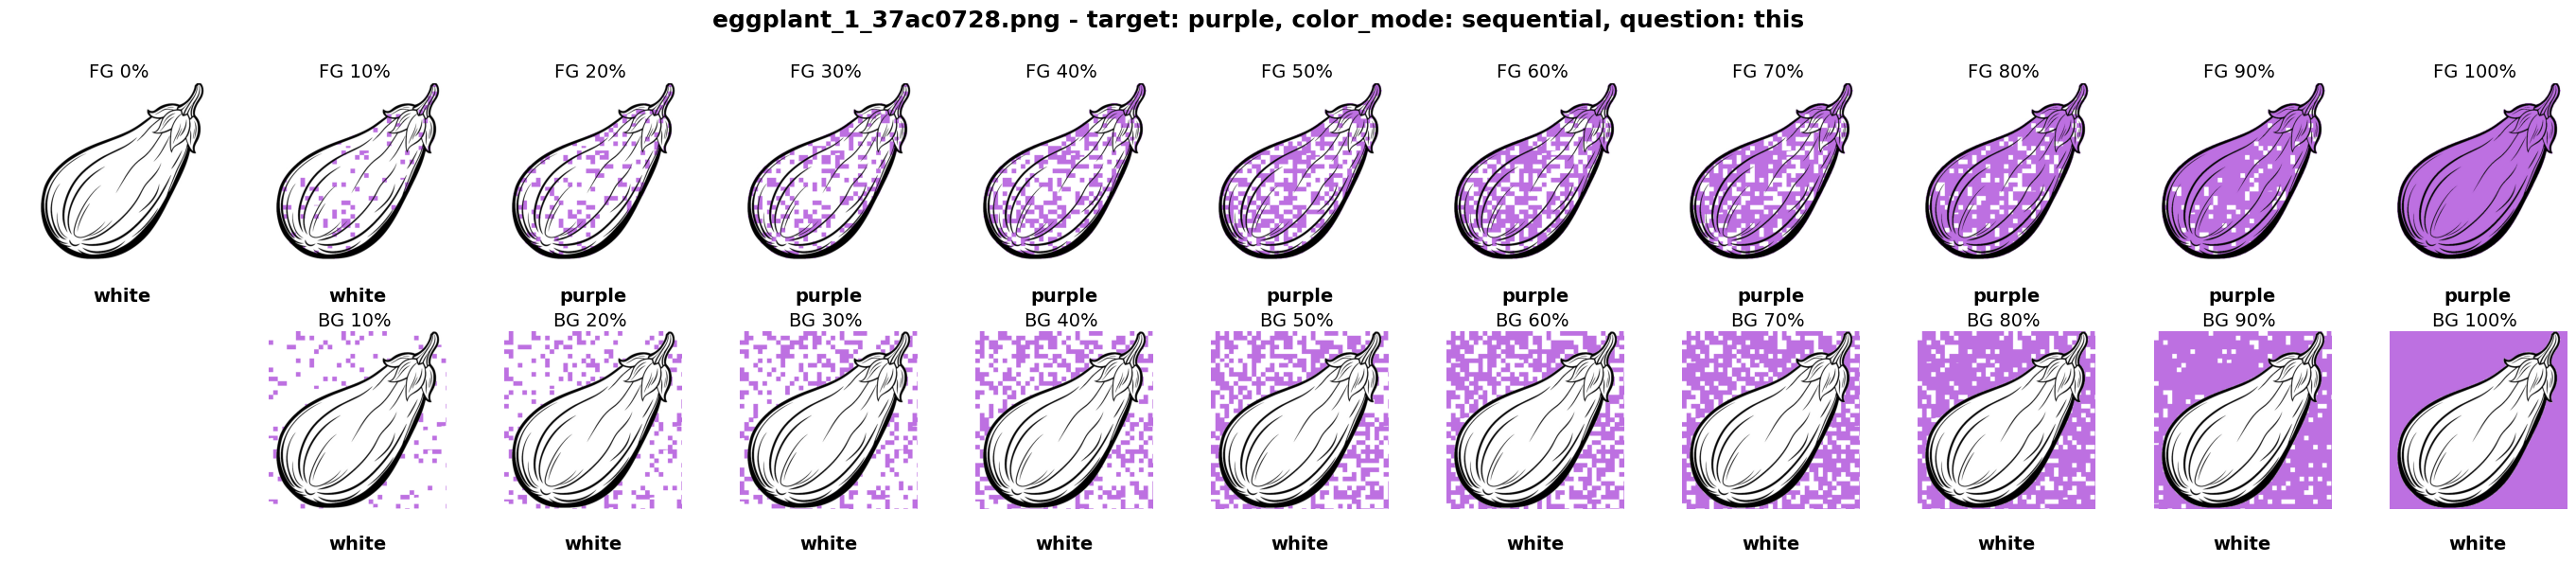

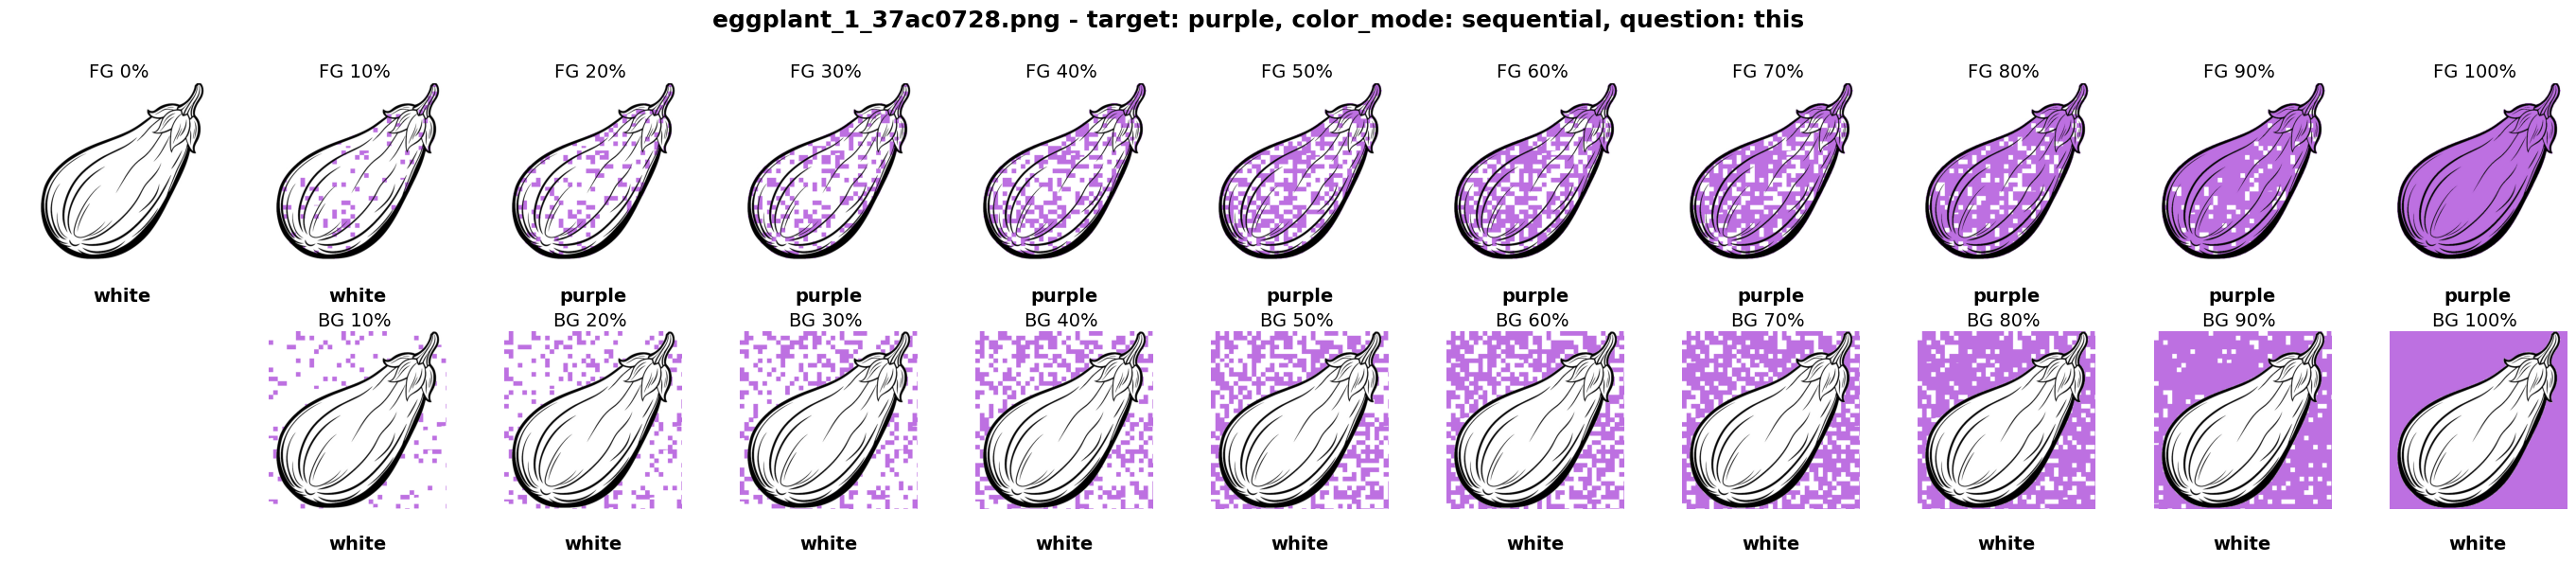

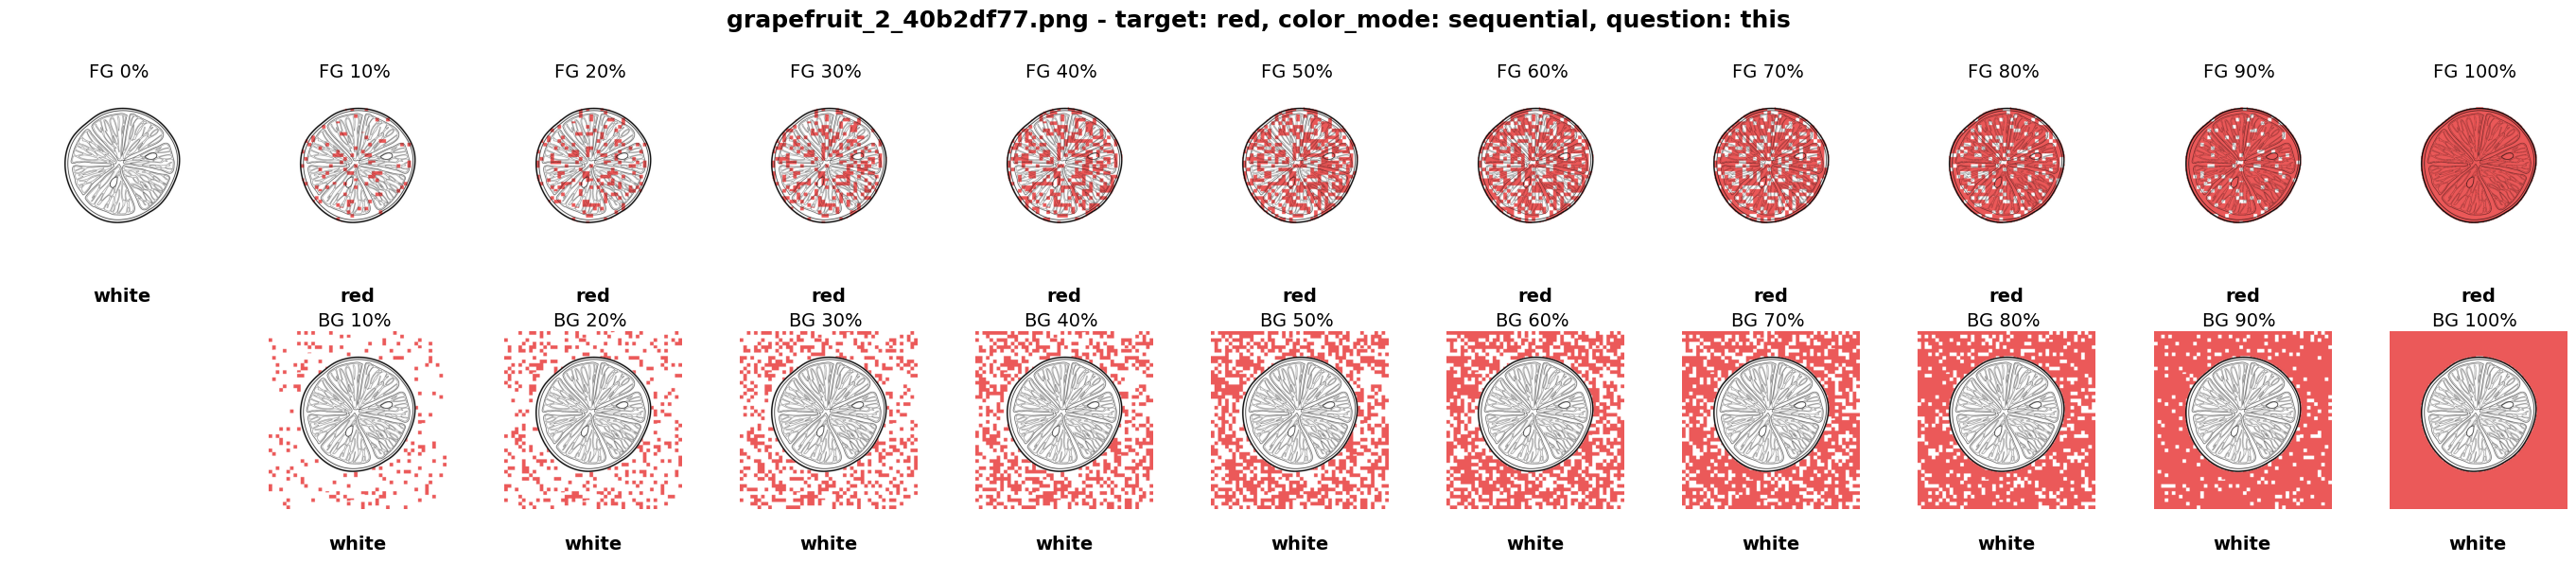

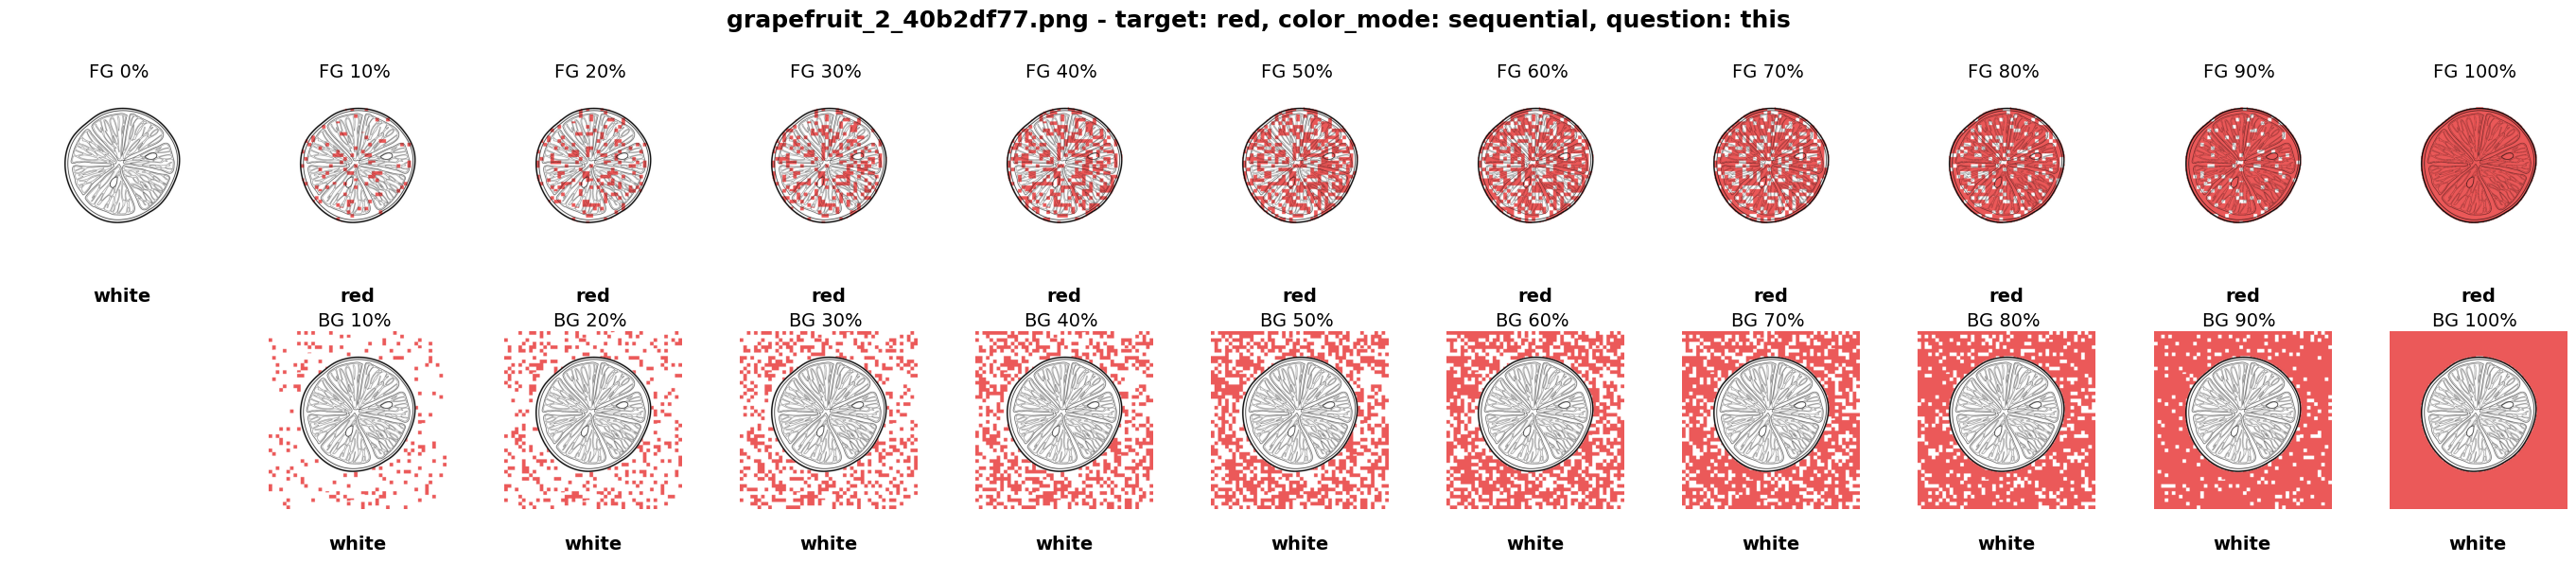

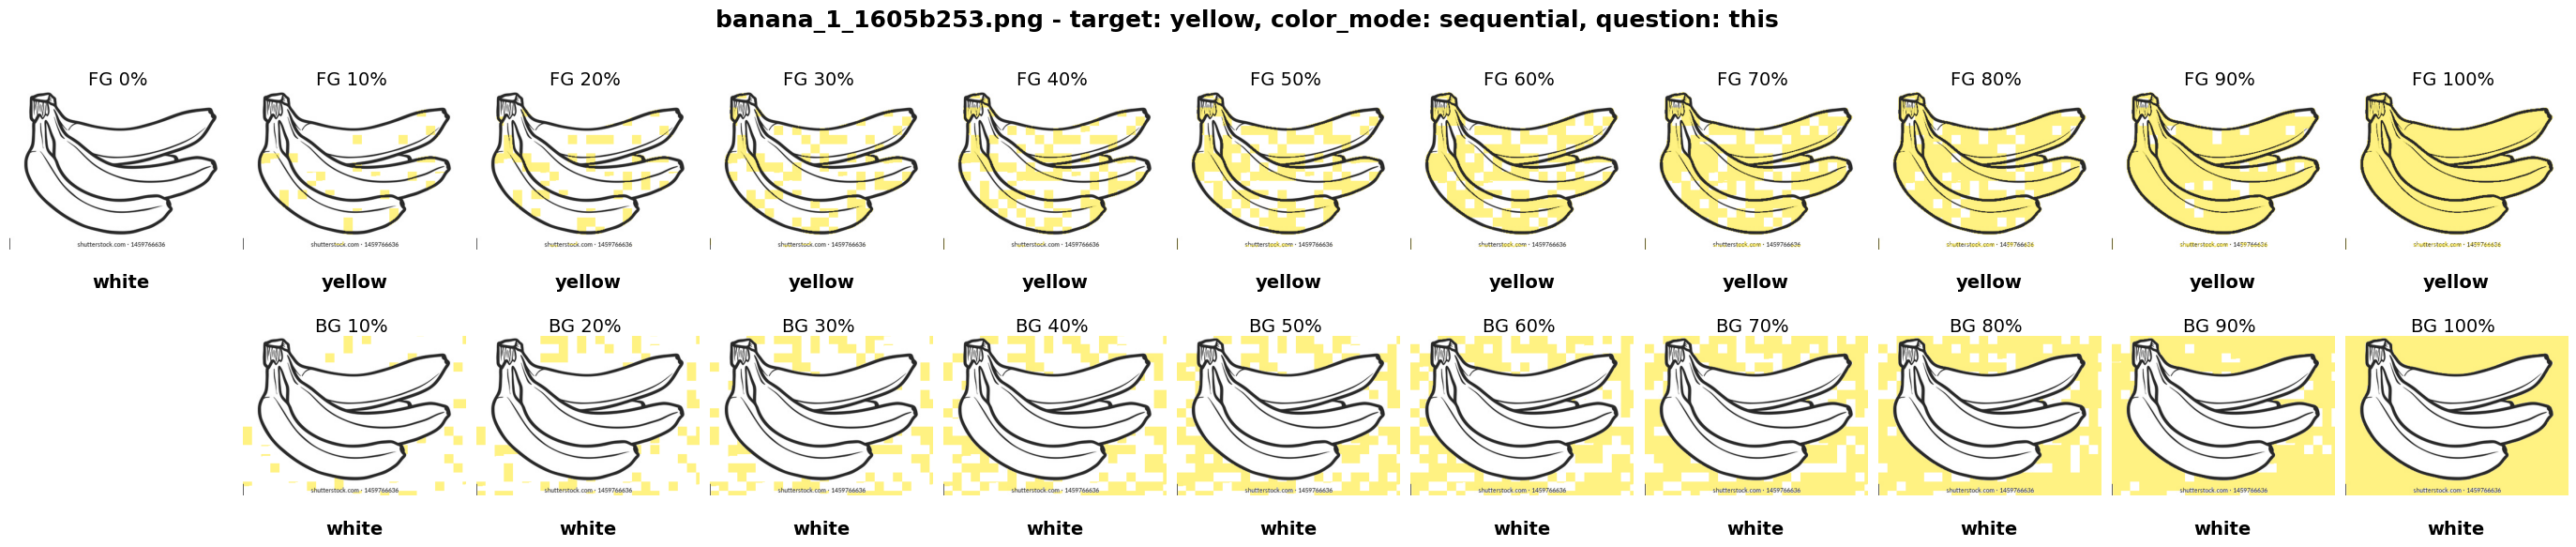

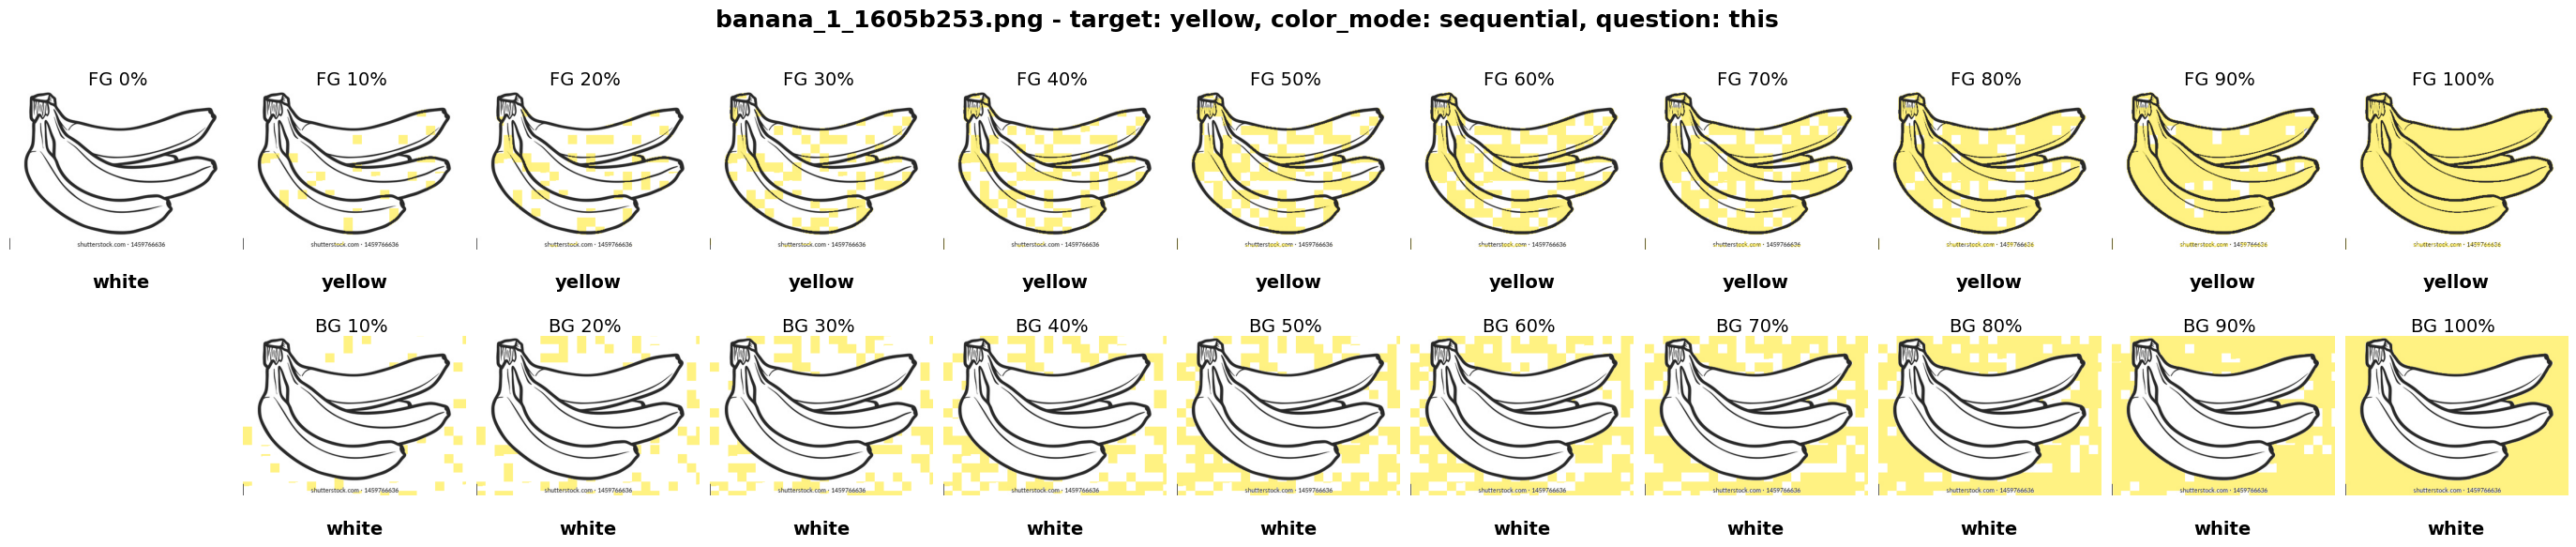

In [ ]:
for idx, row in df.iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row["image_path"], row['correct_answer'], color_outlines, pred_color_df, question="this", color_mode="sequential", pct_range=ten_increase)
        #show_variants_grid(row["image_path"], row['correct_answer'], color_outlines, pred_color_df, question="most", color_mode=color_mode, pct_range=compact)
    

In [ ]:
pred_color_df

object  image_variant correct_answer pred_color_most  \
0     keyboard_(musical)    BG 0% (ind)          black           black   
1     keyboard_(musical)    BG 0% (seq)          black           black   
2     keyboard_(musical)    BG 1% (ind)          black           black   
3     keyboard_(musical)    BG 1% (seq)          black           black   
4     keyboard_(musical)    BG 2% (ind)          black           black   
...                  ...            ...            ...             ...   
1155              banana   FG 98% (seq)         yellow          yellow   
1156              banana   FG 99% (ind)         yellow          yellow   
1157              banana   FG 99% (seq)         yellow          yellow   
1158              banana  FG 100% (ind)         yellow          yellow   
1159              banana  FG 100% (seq)         yellow          yellow   

     pred_color_this  prob_correct_most  prob_correct_this  
0              black           0.592285           0.561523  
1              black           0.592285           0.561523  
2              black           0.584473           0.581543  
3              black           0.614258           0.628418  
4              black           0.562012           0.565430  
...              ...                ...                ...  
1155          yellow           0.986816           0.980957  
1156          yellow           0.985840           0.979004  
1157          yellow           0.986328           0.980957  
1158          yellow           0.987305           0.981934  
1159          yellow           0.987305           0.981934  

[1160 rows x 7 columns]

In [ ]:
modes = ["ind", "seq"]

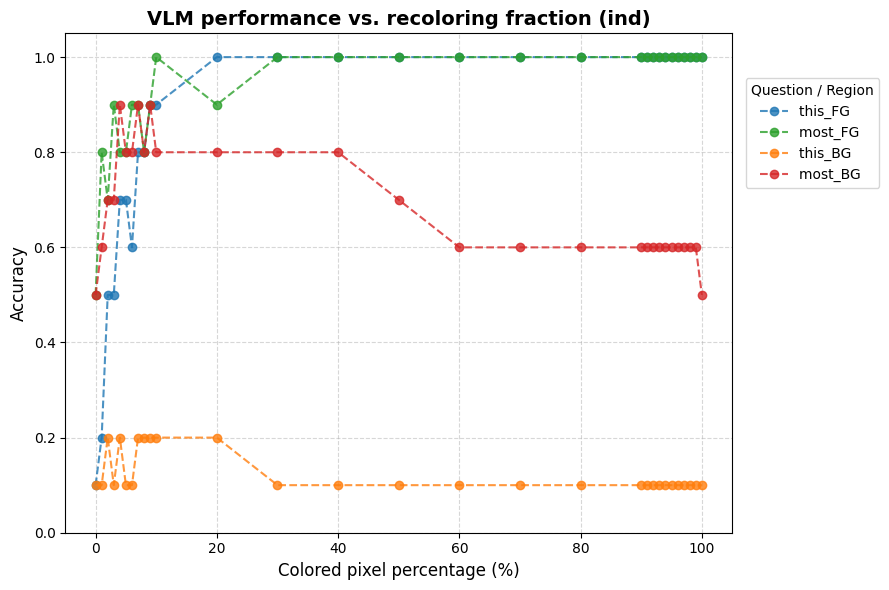

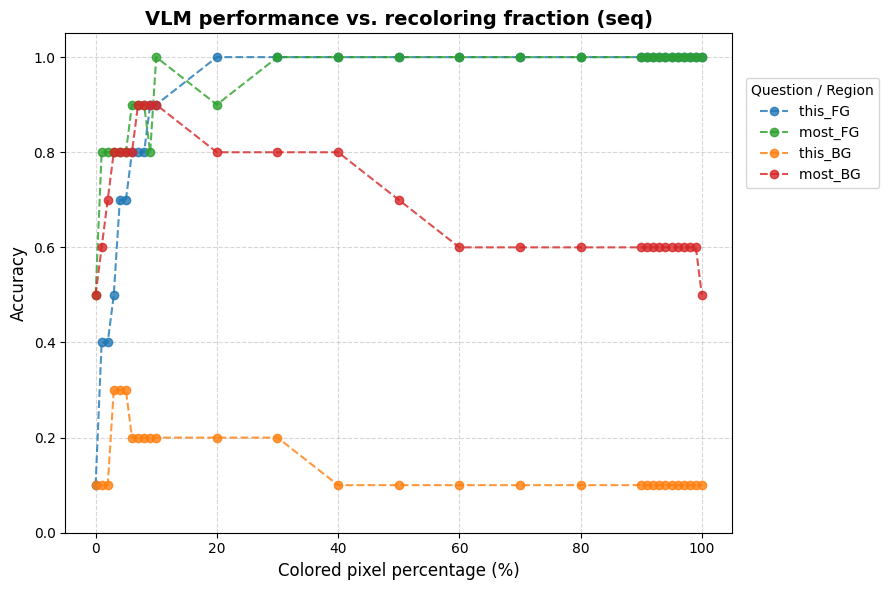

In [ ]:
# Plot full range
for mode in modes:
    plot_vlm_performance(pred_color_df, show_accuracy=True, show_probability=False, color_mode=mode)

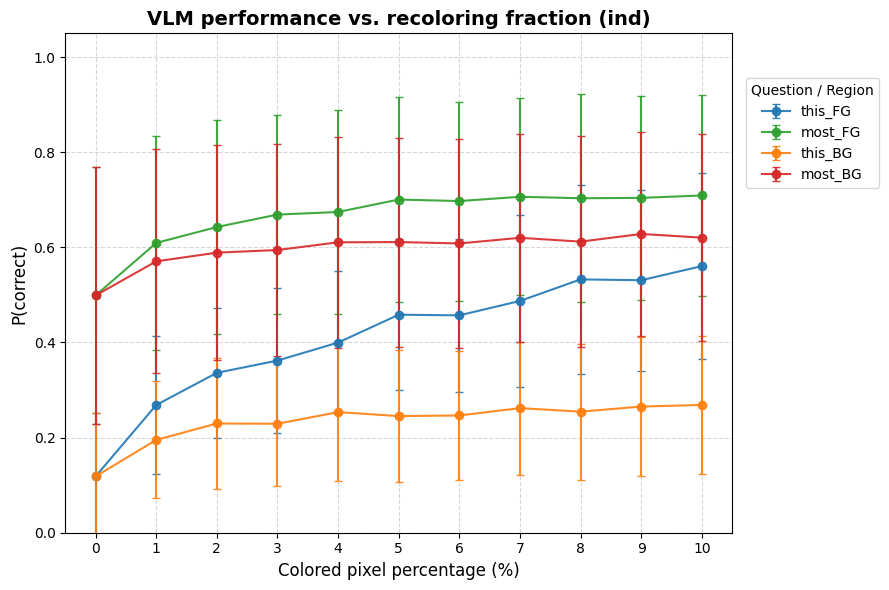

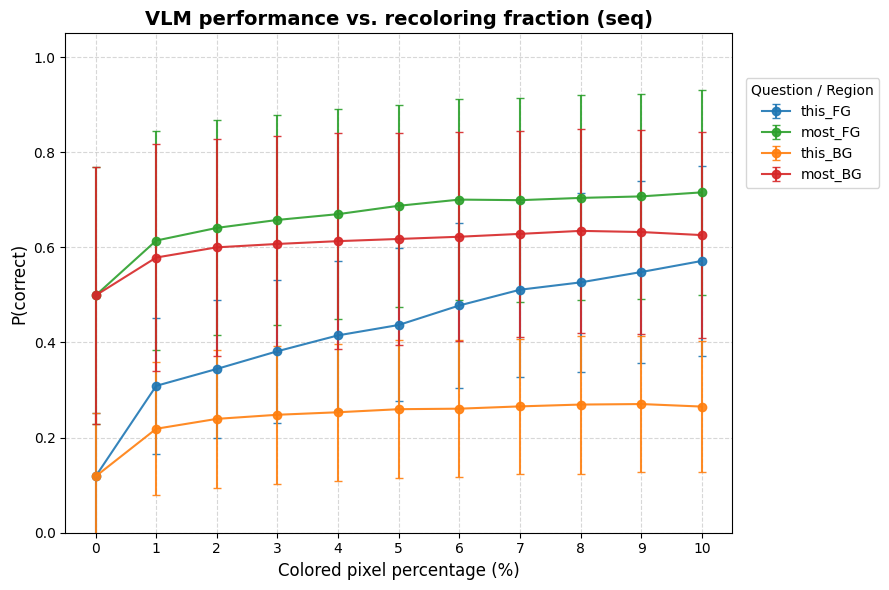

In [ ]:
# Lower range
for mode in modes:
    plot_vlm_performance(pred_color_df, show_accuracy=False, show_probability=True, ci=True, pct_range=range(0, 11), color_mode=mode)

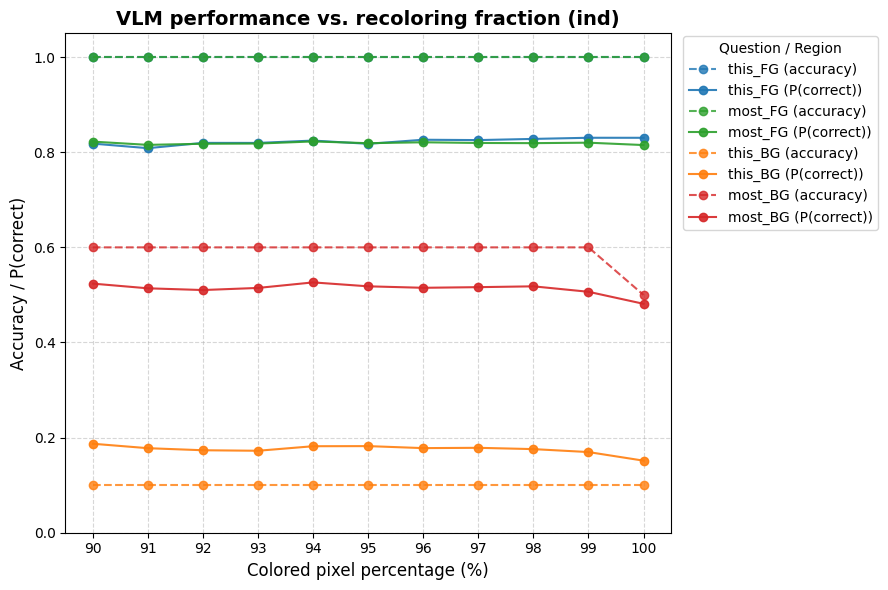

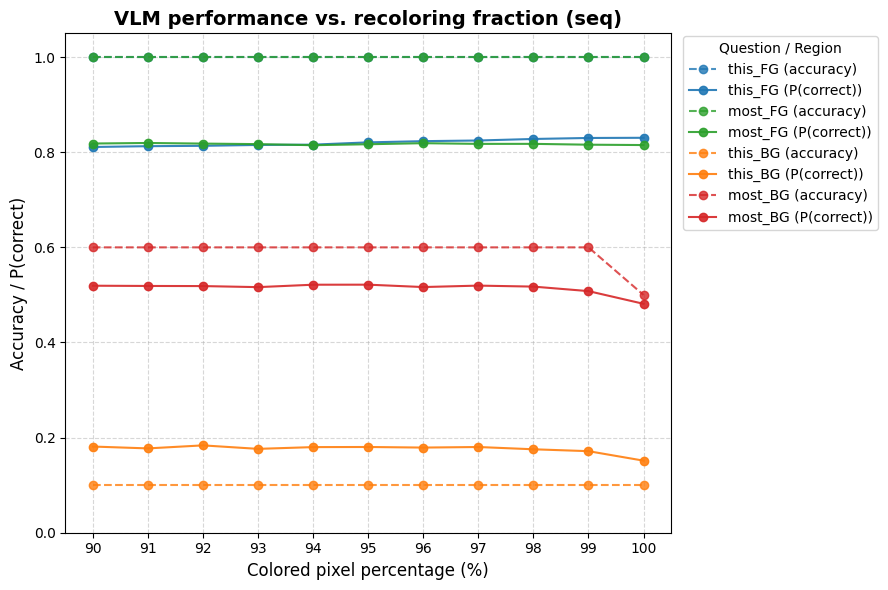

In [ ]:
# Plot end range
for mode in modes:
    plot_vlm_performance(pred_color_df, show_accuracy=True, show_probability=True, pct_range=range(90, 101), color_mode=mode)